# Text Extraction against Sentiments

## Introduction

    Example : Sentence 1: AI is our friend and it has been friendly
              Sentence 2: AI and humans have always been friendly

    === === === === === === === === ===  LEMMATIZATION === === === === === === === === === === === === ===

    In order to calculate similarity using Jaccard similarity, we will first perform lemmatization to reduce words to the same root word. In our case, “friend” and “friendly” will both become 
    "friend”, “has” and “have” will both become “has”.


    === === === === === === === === ===  STOPWORDS === === === === === === === === === === === === === ===

    Stopwords seems controversial to use as it might reduce the acuuracy for successfully differentiating the neutral category

    === === === === === === === === ===  JACCARD  === === === === === === === === === === === === === ===

In [ ]:
#from IPython.display import IFrame
#IFrame('https://en.wikipedia.org/wiki/HTTP', width=800, height=450)

    === === === === === === === === Word-Level Jaccard Score === === === === === === === === === ===    

    A ⋂ B = ( AI,  been, friend, and)

    A ⋃ B = ( AI, have, has, been, friend, and, our, is, it, human, always)

    For the above two sentences, we get Jaccard similarity of 4/11 = 0.3636

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORTING LIBRARIES

In [220]:
!pip install transformers

In [ ]:
!pip install plotly

In [ ]:
!pip install torch

In [2]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 460kB 15.6MB/s 
     |████████████████████████████████| 112kB 19.8MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=1d7ab2931c6bea43f3ece1eb8e4db1469c624eb0b5cdc341e6da6e425bbbc299
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=e2b53341c2d473cb558a1e473aa8c9d022d3128faee9bc1e0bbe53cd7fe57209
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=14bf

In [ ]:
!pip install  cufflinks

In [240]:
!pip install jupyterthemes

     |████████████████████████████████| 7.0MB 2.7MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 9.7MB 34.4MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 501kB 23.8MB/s 
  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427629 sha256=1d576eb1ca75d981d2b5639cc0f13ded42d5b60d03b39b2d3441d7ff17ebf3c5
  Stored in directory: /root/.cache/pip/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
Successfully built tornado
ERROR: google-colab 1.0.0 has requirement notebook~=5.2.0, but you'll have notebook 6.0.3 which is incompatible.
  Found existing installation: tornado 4.5.3
    Uninstalling tornado-4.5.3:
      Successfully uninstalled tornado-4.5.3
  Found existing installation: notebook 5.2.2
    Uninstalling notebook-5.2.2:
      Successfully uninstalled notebook-5.2.2


In [4]:
import numpy as np
import pandas as pd

import os
import re
import nltk
from nltk.corpus import stopwords
import tokenizers
import spacy
import en_core_web_sm
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import json
import wandb
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.figure_factory as ff

import torch
import tensorflow as tf
from transformers import BertTokenizer
import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup



import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='white')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [241]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
# Enabling GPU
use_cuda = True

## 3. EXPLORATORY DATA ANALYSIS

In [ ]:
train_data = pd.read_csv(
    "/content/data/train.csv")
test_data = pd.read_csv(
    "/content/data/test.csv")

In [ ]:
train_data.head()

textID  ... sentiment
0  cb774db0d1  ...   neutral
1  549e992a42  ...  negative
2  088c60f138  ...  negative
3  9642c003ef  ...  negative
4  358bd9e861  ...  negative

[5 rows x 4 columns]

In [ ]:
test_data.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

In [ ]:
train_data.shape

(27481, 4)

In [ ]:
test_data.shape

(3534, 3)

In [ ]:
train_data.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [ ]:
test_data.sentiment.value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

In [ ]:
train_data.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [ ]:
test_data.isnull().sum()


textID       0
text         0
sentiment    0
dtype: int64

Text(0.5, 1.0, 'Sentiment Distribution')

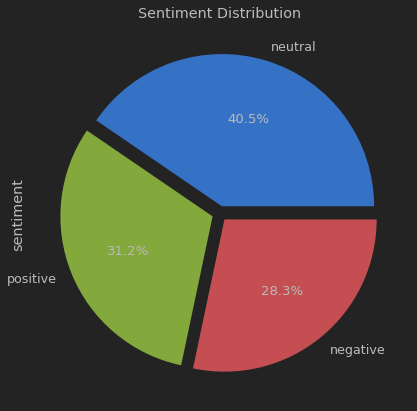

In [ ]:
train_data['sentiment'].value_counts().plot(
    kind='pie', explode=(0.05, 0.05, 0.05), autopct='%1.1f%%')
plt.title('Sentiment Distribution')

Text(0.5, 1.0, 'Sentiment Distribution')

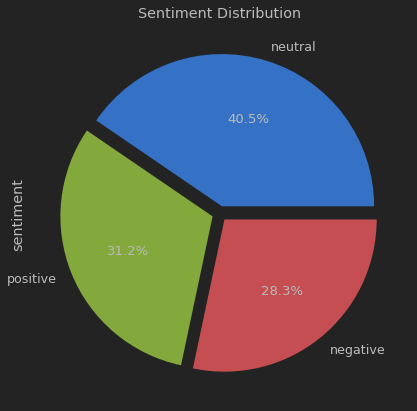

In [ ]:
test_data['sentiment'].value_counts().plot(
    kind='pie', explode=(0.05, 0.05, 0.05), autopct='%1.1f%%')
plt.title('Sentiment Distribution')

In [ ]:
# TEXT LENGHT

train_data['text_len'] = train_data['text'].astype(str).apply(len)
train_data['selected_text_len'] = train_data['selected_text'].astype(
    str).apply(len)

# WORD COUNT
train_data['text_wc'] = train_data['text'].apply(lambda x: len(str(x).split()))
train_data['selected_wc'] = train_data['selected_text'].apply(
    lambda x: len(str(x).split()))

In [ ]:
# TEXT LENGHT

test_data['text_len'] = test_data['text'].astype(str).apply(len)



# WORD COUNT


test_data['text_wc'] = test_data['text'].apply(lambda x: len(str(x).split()))

In [ ]:
train_data.head()

textID  ... selected_wc
0  cb774db0d1  ...           7
1  549e992a42  ...           2
2  088c60f138  ...           2
3  9642c003ef  ...           3
4  358bd9e861  ...           3

[5 rows x 8 columns]

In [ ]:
test_data.head()

textID  ... text_wc
0  f87dea47db  ...       6
1  96d74cb729  ...      15
2  eee518ae67  ...      13
3  01082688c6  ...       2
4  33987a8ee5  ...       5

[5 rows x 5 columns]

In [ ]:
# Dropping missing values
train_data.dropna(axis = 0, how ='any',inplace=True)
train_data.isnull().sum()

textID               0
text                 0
selected_text        0
sentiment            0
text_len             0
selected_text_len    0
text_wc              0
selected_wc          0
dtype: int64

## 4. BASIC VISUALIZATIONS

Text(0.5, 1.0, 'Neutral word count and lenght of train dataset')

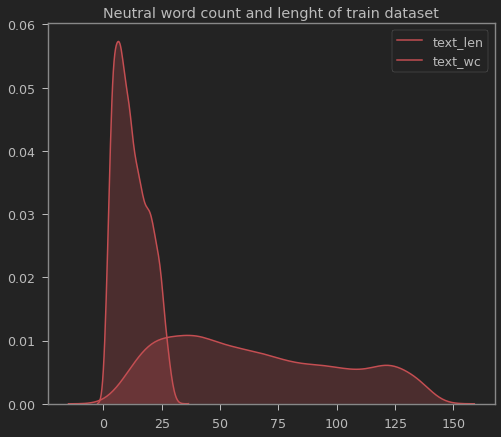

In [ ]:
ax = sns.kdeplot(train_data[train_data.sentiment ==
                            'neutral'].text_len, shade=True, color="r")
ax = sns.kdeplot(train_data[train_data.sentiment ==
                            'neutral'].text_wc, shade=True, color="r")
ax.set_title('Neutral word count and lenght of train dataset')

Text(0.5, 1.0, 'Neutral word count and lenght of test dataset')

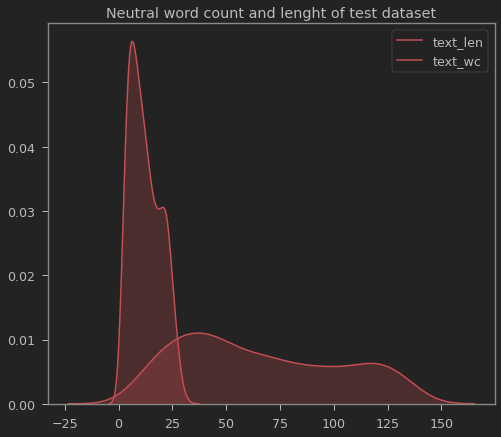

In [ ]:
ax = sns.kdeplot(test_data[test_data.sentiment ==
                           'neutral'].text_len, shade=True, color="r")
ax = sns.kdeplot(test_data[test_data.sentiment ==
                           'neutral'].text_wc, shade=True, color="r")
ax.set_title('Neutral word count and lenght of test dataset')

Text(0.5, 1.0, 'Positive word count and lenght of train dataset')

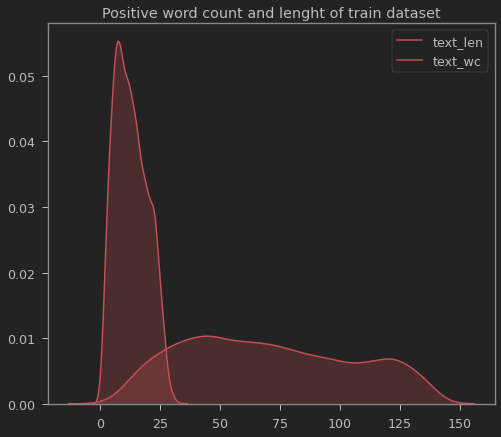

In [ ]:
ax = sns.kdeplot(train_data[train_data.sentiment ==
                            'positive'].text_len, shade=True, color="r")
ax = sns.kdeplot(train_data[train_data.sentiment ==
                            'positive'].text_wc, shade=True, color="r")
ax.set_title('Positive word count and lenght of train dataset')

Text(0.5, 1.0, 'Positive word count and lenght of test dataset')

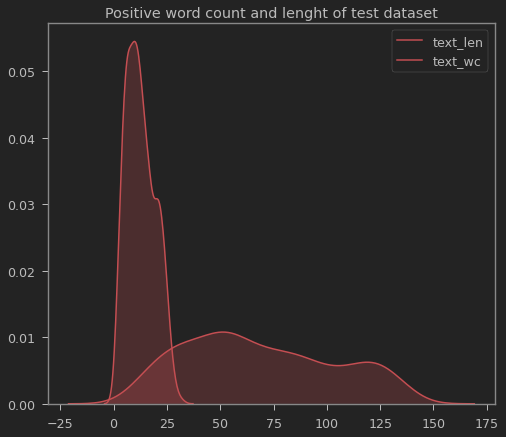

In [ ]:
ax = sns.kdeplot(test_data[test_data.sentiment ==
                           'positive'].text_len, shade=True, color="r")
ax = sns.kdeplot(test_data[test_data.sentiment ==
                           'positive'].text_wc, shade=True, color="r")
ax.set_title('Positive word count and lenght of test dataset')

Text(0.5, 1.0, 'Negative word count and lenght of train dataset')

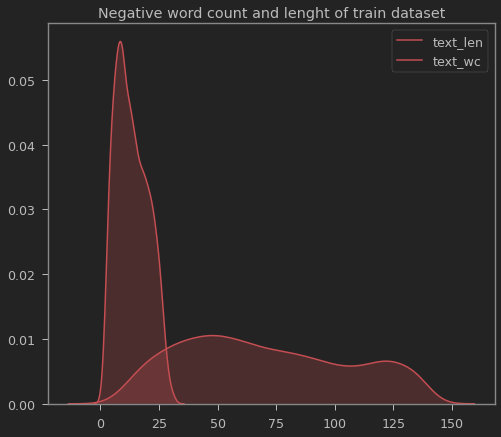

In [ ]:
ax = sns.kdeplot(train_data[train_data.sentiment ==
                            'negative'].text_len, shade=True, color="r")
ax = sns.kdeplot(train_data[train_data.sentiment ==
                            'negative'].text_wc, shade=True, color="r")
ax.set_title('Negative word count and lenght of train dataset')

Text(0.5, 1.0, 'Negative word count and lenght of test dataset')

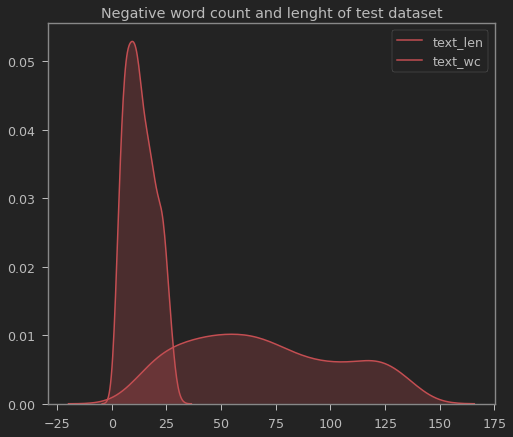

In [ ]:
ax = sns.kdeplot(test_data[test_data.sentiment ==
                           'negative'].text_len, shade=True, color="r")
ax = sns.kdeplot(test_data[test_data.sentiment ==
                           'negative'].text_wc, shade=True, color="r")
ax.set_title('Negative word count and lenght of test dataset')

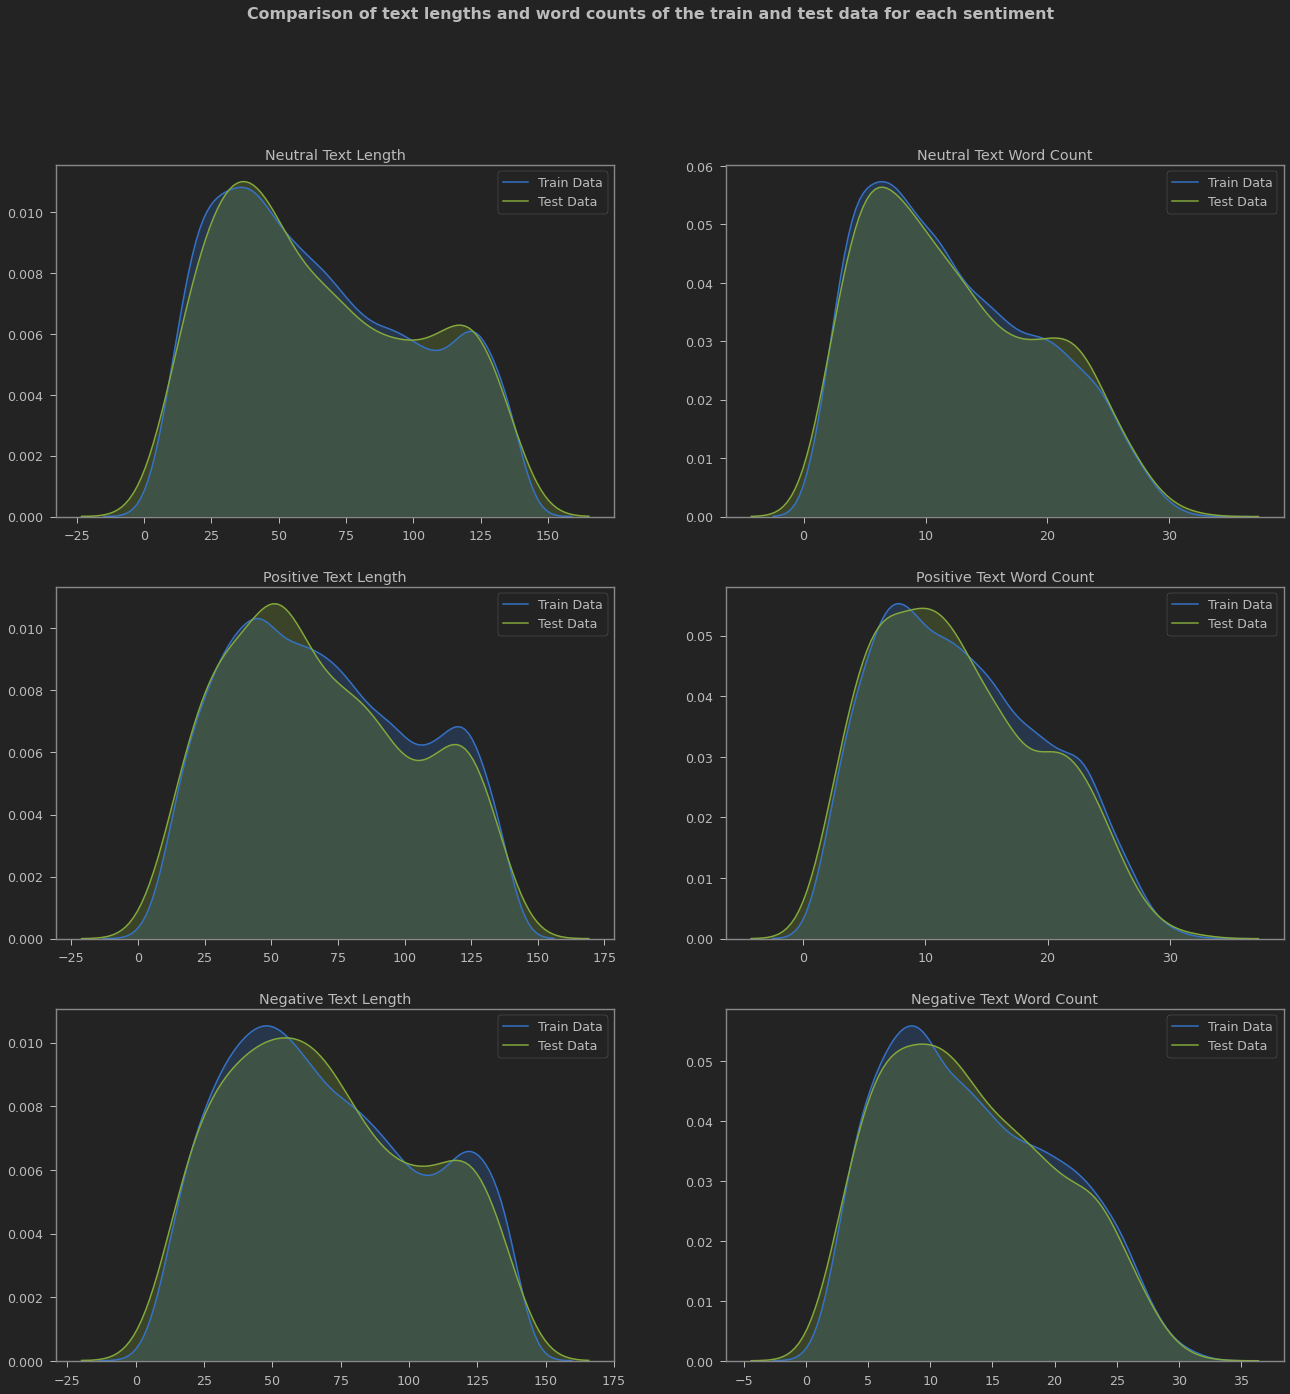

In [ ]:
fig, (ax) = plt.subplots(3, 2, figsize=(22, 22))
sns.kdeplot(train_data[train_data.sentiment ==
                       "neutral"].text_len, shade=True, ax=ax[0][0])
sns.kdeplot(test_data[test_data.sentiment ==
                      "neutral"].text_len, shade=True, ax=ax[0][0])
sns.kdeplot(train_data[train_data.sentiment ==
                       "neutral"].text_wc, shade=True, ax=ax[0][1])
sns.kdeplot(test_data[test_data.sentiment ==
                      "neutral"].text_wc, shade=True, ax=ax[0][1])
ax[0][0].set_title("Neutral Text Length")
ax[0][1].set_title("Neutral Text Word Count")
ax[0][0].legend(['Train Data', 'Test Data'])
ax[0][1].legend(['Train Data', 'Test Data'])

sns.kdeplot(train_data[train_data.sentiment ==
                       "positive"].text_len, shade=True, ax=ax[1][0])
sns.kdeplot(test_data[test_data.sentiment ==
                      "positive"].text_len, shade=True, ax=ax[1][0])
sns.kdeplot(train_data[train_data.sentiment ==
                       "positive"].text_wc, shade=True, ax=ax[1][1])
sns.kdeplot(test_data[test_data.sentiment ==
                      "positive"].text_wc, shade=True, ax=ax[1][1])
ax[1][0].set_title("Positive Text Length")
ax[1][1].set_title("Positive Text Word Count")
ax[1][0].legend(['Train Data', 'Test Data'])
ax[1][1].legend(['Train Data', 'Test Data'])

sns.kdeplot(train_data[train_data.sentiment ==
                       "negative"].text_len, shade=True, ax=ax[2][0])
sns.kdeplot(test_data[test_data.sentiment ==
                      "negative"].text_len, shade=True, ax=ax[2][0])
sns.kdeplot(train_data[train_data.sentiment ==
                       "negative"].text_wc, shade=True, ax=ax[2][1])
sns.kdeplot(test_data[test_data.sentiment ==
                      "negative"].text_wc, shade=True, ax=ax[2][1])
ax[2][0].set_title("Negative Text Length")
ax[2][1].set_title("Negative Text Word Count")
ax[2][0].legend(['Train Data', 'Test Data'])
ax[2][1].legend(['Train Data', 'Test Data'])

plt.suptitle(
    "Comparison of text lengths and word counts of the train and test data for each sentiment", fontweight="bold")
plt.show()

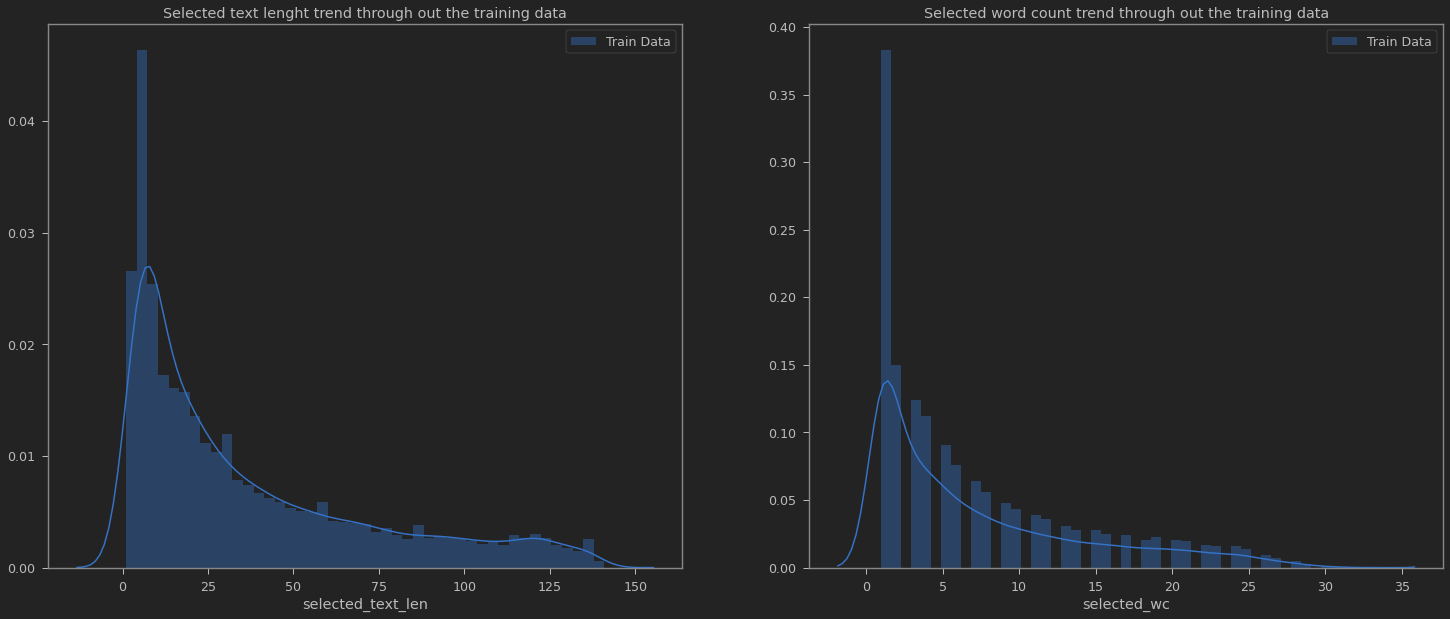

In [ ]:
fig, (ax) = plt.subplots(1, 2, figsize=(25, 10))

sns.distplot(train_data.selected_text_len, norm_hist=True, ax=ax[0])
ax[0].set_title("Selected text lenght trend through out the training data")
ax[0].legend(['Train Data', 'Test Data'])

sns.distplot(train_data.selected_wc, norm_hist=True, ax=ax[1])
ax[1].set_title("Selected word count trend through out the training data")
ax[1].legend(['Train Data', 'Test Data'])

In [ ]:
# === === === === ==== === === === === === === === === === Selected Word Count in Train Data set === === === === === === === === === === === === === === === === ===

Text(0.5, 1.0, 'Train Sentiment analysis against total words')

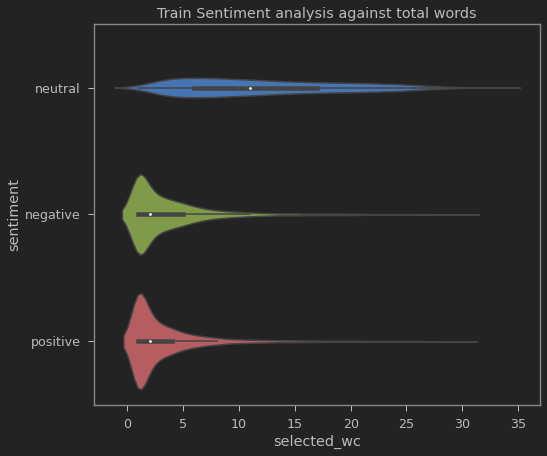

In [ ]:
sns.violinplot(x=train_data['selected_wc'], y=train_data['sentiment'], data=train_data, order=None,
               hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.758, inner='box', split=False,
               dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None)
plt.title('Train Sentiment analysis against total words')

Text(0.5, 1.0, 'Train Sentiment analysis against total lenght of selected words')

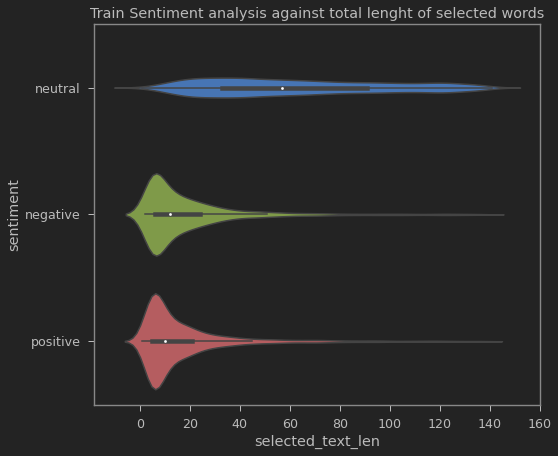

In [ ]:
sns.violinplot(x=train_data['selected_text_len'], y=train_data['sentiment'], data=train_data, order=None,
               hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.758, inner='box', split=False,
               dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None)
plt.title('Train Sentiment analysis against total lenght of selected words')

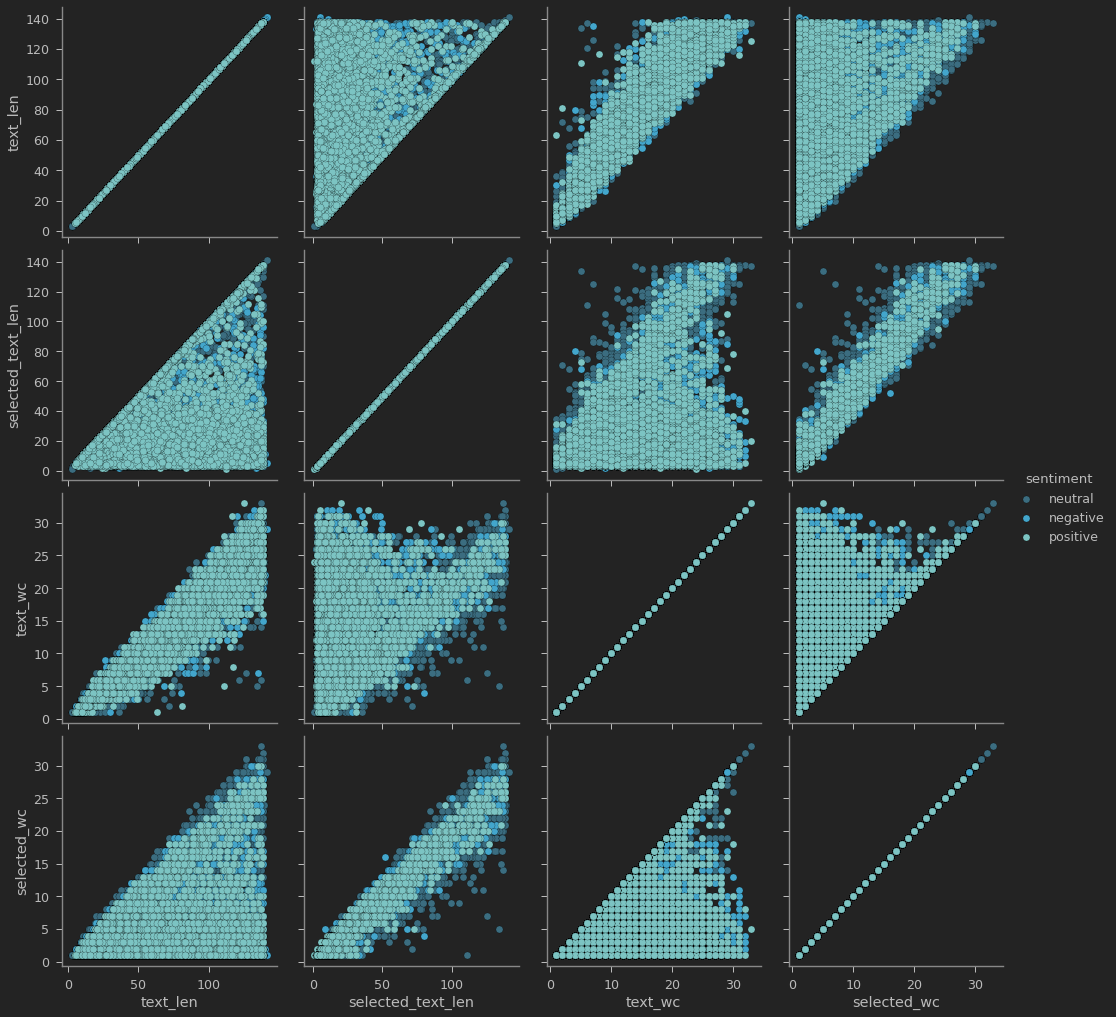

In [ ]:
g = sns.PairGrid(train_data, height=3.5, hue='sentiment', palette="GnBu_d")
g.map(plt.scatter, s=50, edgecolor="black")
g.add_legend()

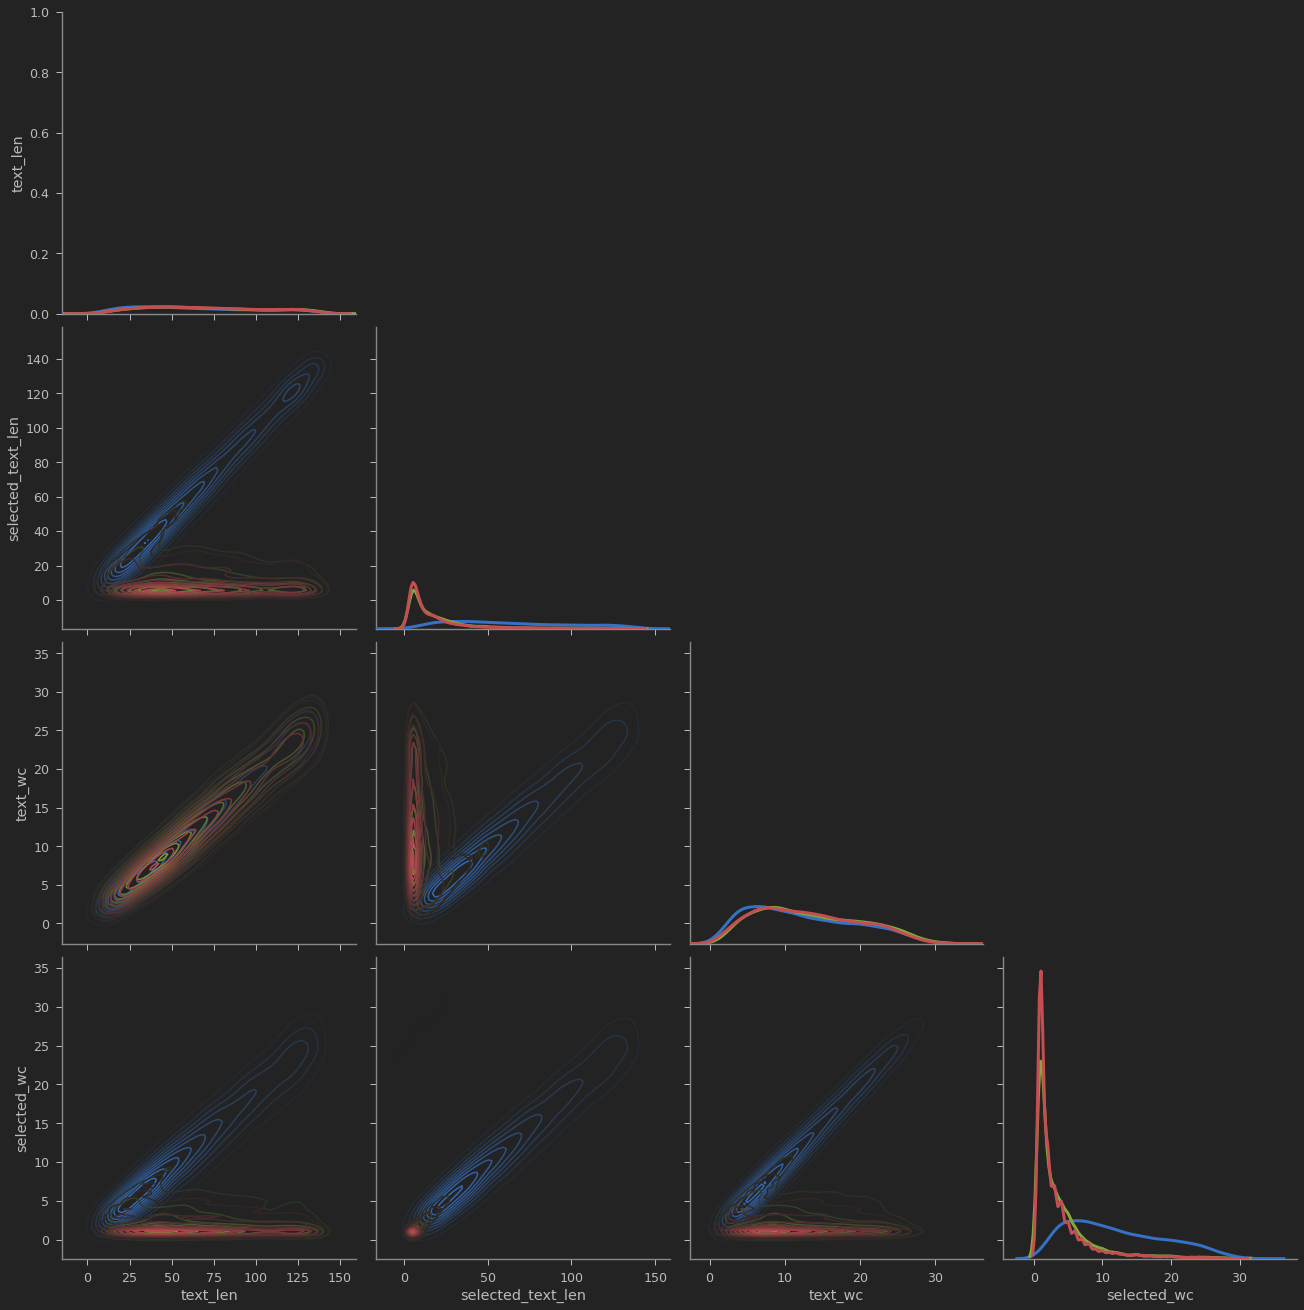

In [ ]:
g = sns.PairGrid(train_data, hue="sentiment", height=4.5)


def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)


g.map_upper(hide_current_axis)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [ ]:
# # === === === === ==== === === === === === === === === === Correlation === === === === === === === === === === === === === === === === ===

In [ ]:
train_data.corr()

text_len  selected_text_len   text_wc  selected_wc
text_len           1.000000           0.433927  0.961234     0.421739
selected_text_len  0.433927           1.000000  0.423983     0.981059
text_wc            0.961234           0.423983  1.000000     0.449511
selected_wc        0.421739           0.981059  0.449511     1.000000

## 5. TEXT/WORD ANALYSIS AND EXPLORATION

### Exploring Jaccard Similarity

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
train_data.text=train_data.text.astype(str)
train_data.selected_text= train_data.selected_text.astype(str)
train_data['jaccard_score'] = train_data.apply(lambda row:jaccard(row["text"],row["selected_text"]),axis=1)

In [ ]:
train_data.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'text_len',
       'selected_text_len', 'text_wc', 'selected_wc', 'jaccard_score'],
      dtype='object')

In [ ]:
train_data[:315]

textID  ... jaccard_score
0    cb774db0d1  ...      1.000000
1    549e992a42  ...      0.200000
2    088c60f138  ...      0.166667
3    9642c003ef  ...      0.600000
4    358bd9e861  ...      0.214286
..          ...  ...           ...
310  5b578d0b4c  ...      0.058824
311  c4ab28566e  ...      1.000000
312  162a2510d2  ...      0.250000
313  c25871ec9e  ...      0.045455
315  ddd4dd7be4  ...      1.000000

[315 rows x 9 columns]

In [ ]:
train_data.groupby('sentiment')['jaccard_score'].mean()

sentiment
negative    0.338613
neutral     0.976445
positive    0.314372
Name: jaccard_score, dtype: float64

In [ ]:
train_data.groupby('sentiment').mean()

text_len  selected_text_len    text_wc  selected_wc  jaccard_score
sentiment                                                                     
negative   70.488112          19.970698  13.473204     3.957975       0.338613
neutral    65.206800          62.765134  12.343888    12.069533       0.976445
positive   70.419133          18.124680  13.109881     3.519343       0.314372

Text(0.5, 1.0, 'Neutral')

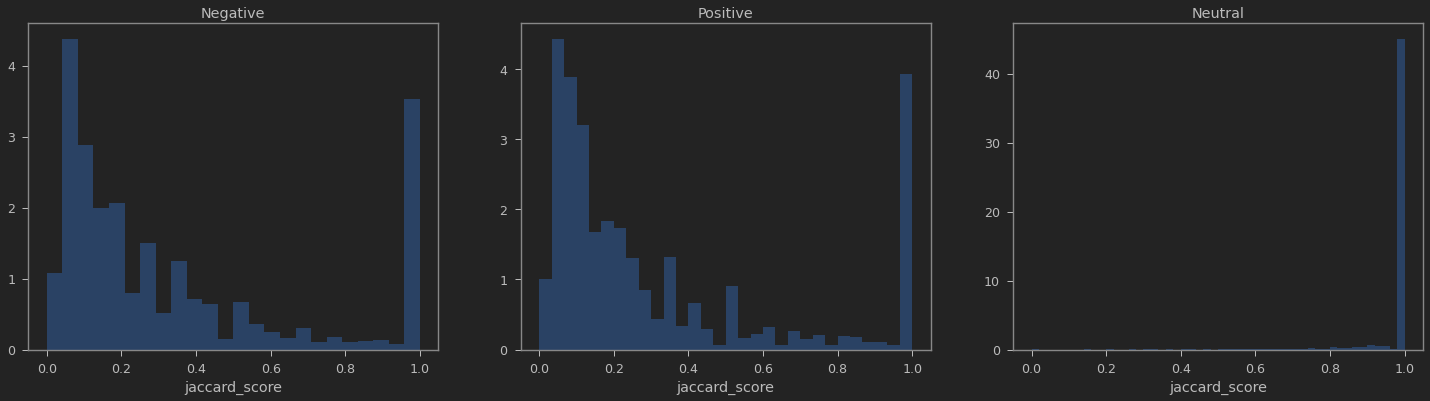

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,6))
sns.distplot(train_data.loc[train_data['sentiment']=="negative","jaccard_score"],kde = False,ax=ax1,norm_hist=True)
ax1.set_title('Negative')
sns.distplot(train_data.loc[train_data['sentiment']=="positive","jaccard_score"],kde = False,ax=ax2,norm_hist=True)
ax2.set_title('Positive')
sns.distplot(train_data.loc[train_data['sentiment']=="neutral","jaccard_score"],kde = False,ax=ax3,norm_hist=True)
ax3.set_title('Neutral')

In [ ]:
train_data.text.str.split(' ')

0            [, I`d, have, responded,, if, I, were, going]
1        [, Sooo, SAD, I, will, miss, you, here, in, Sa...
2                          [my, boss, is, bullying, me...]
3                   [, what, interview!, leave, me, alone]
4        [, Sons, of, ****,, why, couldn`t, they, put, ...
                               ...                        
27476    [, wish, we, could, come, see, u, on, Denver, ...
27477    [, I`ve, wondered, about, rake, to., , The, cl...
27478    [, Yay, good, for, both, of, you., Enjoy, the,...
27479                 [, But, it, was, worth, it, , ****.]
27480    [, , , All, this, flirting, going, on, -, The,...
Name: text, Length: 27480, dtype: object

## 5. Text Cleaning   

In [ ]:
'''
train_data['raw_text'] = train_data['text']
train_data

https://www.kaggle.com/rinnqd/is-this-a-leak-or-magic
https://www.kaggle.com/futureboykid/2nd-place-post-processing
https://www.kaggle.com/jonathanbesomi/private-test-not-that-private-afterall
https://github.com/sarnthil/unify-emotion-datasets/tree/master/datasets
https://www.kaggle.com/rohitsingh9990/preprocessing-that-worked
https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/159499
https://app.wandb.ai/cayush/bert-finetuning/reports/Sentence-classification-with-Huggingface-BERT-and-W%26B--Vmlldzo4MDMwNA
https://keras.io/examples/nlp/text_extraction_with_bert/

'''

"\ntrain_data['raw_text'] = train_data['text']\ntrain_data\n\nhttps://www.kaggle.com/rinnqd/is-this-a-leak-or-magic\nhttps://www.kaggle.com/futureboykid/2nd-place-post-processing\nhttps://www.kaggle.com/jonathanbesomi/private-test-not-that-private-afterall\nhttps://github.com/sarnthil/unify-emotion-datasets/tree/master/datasets\nhttps://www.kaggle.com/rohitsingh9990/preprocessing-that-worked\nhttps://www.kaggle.com/c/tweet-sentiment-extraction/discussion/159499\nhttps://app.wandb.ai/cayush/bert-finetuning/reports/Sentence-classification-with-Huggingface-BERT-and-W%26B--Vmlldzo4MDMwNA\nhttps://keras.io/examples/nlp/text_extraction_with_bert/\n\n"

In [ ]:
'''
import re
def pp(filtered_output, real_tweet):
    filtered_output = ' '.join(filtered_output.split())
    if len(real_tweet.split()) < 2:
        filtered_output = real_tweet
    else:
        if len(filtered_output.split()) == 1:
            if filtered_output.endswith(".."):
                if real_tweet.startswith(" "):
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\.)\1{2,}', '', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\.)\1{2,}', '.', filtered_output)
                else:
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\.)\1{2,}', '.', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\.)\1{2,}', '..', filtered_output)
                return filtered_output
            if filtered_output.endswith('!!'):
                if real_tweet.startswith(" "):
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\!)\1{2,}', '', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!', filtered_output)
                else:
                    st = real_tweet.find(filtered_output)
                    fl = real_tweet.find("  ")
                    if fl != -1 and fl < st:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!', filtered_output)
                    else:
                        filtered_output = re.sub(r'(\!)\1{2,}', '!!', filtered_output)
                return filtered_output

        if real_tweet.startswith(" "):
            filtered_output = filtered_output.strip()
            text_annotetor = ' '.join(real_tweet.split())
            start = text_annotetor.find(filtered_output)
            end = start + len(filtered_output)
            start -= 0
            end += 2
            flag = real_tweet.find("  ")
            if flag < start:
                filtered_output = real_tweet[start:end]

        if "  " in real_tweet and not real_tweet.startswith(" "):
            filtered_output = filtered_output.strip()
            text_annotetor = re.sub(" {2,}", " ", real_tweet)
            start = text_annotetor.find(filtered_output)
            end = start + len(filtered_output)
            start -= 0
            end += 2
            flag = real_tweet.find("  ")
            if flag < start:
                filtered_output = real_tweet[start:end]
    return filtered_output
'''

'\nimport re\ndef pp(filtered_output, real_tweet):\n    filtered_output = \' \'.join(filtered_output.split())\n    if len(real_tweet.split()) < 2:\n        filtered_output = real_tweet\n    else:\n        if len(filtered_output.split()) == 1:\n            if filtered_output.endswith(".."):\n                if real_tweet.startswith(" "):\n                    st = real_tweet.find(filtered_output)\n                    fl = real_tweet.find("  ")\n                    if fl != -1 and fl < st:\n                        filtered_output = re.sub(r\'(\\.)\x01{2,}\', \'\', filtered_output)\n                    else:\n                        filtered_output = re.sub(r\'(\\.)\x01{2,}\', \'.\', filtered_output)\n                else:\n                    st = real_tweet.find(filtered_output)\n                    fl = real_tweet.find("  ")\n                    if fl != -1 and fl < st:\n                        filtered_output = re.sub(r\'(\\.)\x01{2,}\', \'.\', filtered_output)\n                    els

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    return "".join(text) # converting return value from list to string

In [ ]:
# Applying the cleaning function to both test and training datasets
train_data['text_clean'] = train_data['text'].apply(str).apply(lambda x: text_preprocessing(x))
test_data['text_clean'] = test_data['text'].apply(str).apply(lambda x: text_preprocessing(x))

#### Selected text analyzing 

In [ ]:
'''
nlp = en_core_web_sm.load()
text = train_data.selected_text
i = len(text)-1
for i in train_data[i]:
    doc = nlp(text)
    for entity in doc.ents:
        print(entity.text, entity.label_)
=== =================================================================================
####
#Example
nlp = en_core_web_sm.load()

# Process whole documents
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)
####    
====================================================================================
'''

'\nnlp = en_core_web_sm.load()\ntext = train_data.selected_text\ni = len(text)-1\nfor i in train_data[i]:\n    doc = nlp(text)\n    for entity in doc.ents:\n        print(entity.text, entity.label_)\n=== =================================================================================\n####\n#Example\nnlp = en_core_web_sm.load()\n\n# Process whole documents\ntext = ("When Sebastian Thrun started working on self-driving cars at "\n        "Google in 2007, few people outside of the company took him "\n        "seriously. “I can tell you very senior CEOs of major American "\n        "car companies would shake my hand and turn away because I wasn’t "\n        "worth talking to,” said Thrun, in an interview with Recode earlier "\n        "this week.")\ndoc = nlp(text)\n\n# Analyze syntax\nprint("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])\nprint("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])\n\n# Find named entities, phrases and concepts\nfor entity in doc

#### Noise in dataset  

In [ ]:
'''
https://www.kaggle.com/rinnqd/is-this-a-leak-or-magic
https://www.kaggle.com/jonathanbesomi/private-test-not-that-private-afterall
'''
# noise like train_data[27469:]
def find_all(word, text):
  
    word = word.replace(".","\.")
    word = word.replace(")","\)")
    word = word.replace("(","\(")
    word = word.replace("?","\?")
    word = word.replace("!","\!")
    word = word.replace("*","\*")
    word = word.replace("$","\$")
    word = word.replace("[","\[")
    word = word.replace("]","\]")
    word = word.replace("+","\+")
    # .start() tells you the index of the starting position of the match
    # re.findter() iterates through the whole expression and for a certain word.  
    return [m.start() for m in re.finditer(word, text)]
               
def extract_end_index(text, selected_text):
    i=0
    last_word = selected_text.split()[-1] # Extracting last word
    index_last_word = find_all(last_word, text) # getting the last word indexes
    n_occ = len(index_last_word) # last word occurance in the sentence
    
    selected_text_split = selected_text.split()
    text_split = text.split() ## adding the total # of words in selected_text with the index
    n_end = 0
    if len(selected_text_split)==len(text_split):
        return len(text)
    for j, elm in enumerate(text_split[len(selected_text_split):]):
        i = j + len(selected_text_split)
        if elm == last_word :
            n_end +=1
            if text_split[j+1:i+1] == selected_text_split:
                break
   
    return index_last_word[n_end-1] + len(selected_text_split[-1])

def extract_start_index(text, selected_text):
    first_word = selected_text.split()[0]
    index_first_word = find_all(first_word, text)
    n_occ = len(index_first_word)
    
    selected_text_split = selected_text.split()
    text_split = text.split()
    n_start = 0
    for i, elm in enumerate(text_split):
        if (first_word !=elm) and (first_word in elm):
            n_start += elm.count(first_word)
        if elm == first_word :
            n_start +=1
            if text_split[i:i+len(selected_text_split)] == selected_text_split:
                break
    return index_first_word[n_start-1]

In [ ]:
'''
train_data.text[2]

text = 'my boss is bullying me'
selected_text = "bullying me"
[m.start() for m in re.finditer(selected_text,text)]
word_occurance = len(index_last_word)


selected_text_split = selected_text.split()
text_split = text.split()

n_end = 0

a = text_split[len(selected_text_split):]
print(a)
print(selected_text_split)
print(text_split)
print(len(selected_text_split))
'''

'\ntrain_data.text[2]\n\ntext = \'my boss is bullying me\'\nselected_text = "bullying me"\n[m.start() for m in re.finditer(selected_text,text)]\nword_occurance = len(index_last_word)\n\n\nselected_text_split = selected_text.split()\ntext_split = text.split()\n\nn_end = 0\n\na = text_split[len(selected_text_split):]\nprint(a)\nprint(selected_text_split)\nprint(text_split)\nprint(len(selected_text_split))\n'

In [ ]:
'''
test = 'my boss is bullying me'
[m.start() for m in re.finditer('is', 'my boss is bullying me')]

test2 = 'test test test test'
[m.start() for m in re.finditer('test', 'test test test test')]
'''

"\ntest = 'my boss is bullying me'\n[m.start() for m in re.finditer('is', 'my boss is bullying me')]\n\ntest2 = 'test test test test'\n[m.start() for m in re.finditer('test', 'test test test test')]\n"

In [ ]:
'''
text = 'my boss is bullying me'
selected_text = "bullying me"
text = set(str(text).split())
selected_text = set(str(selected_text).split())
selected_text.issubset(text)
'''

'\ntext = \'my boss is bullying me\'\nselected_text = "bullying me"\ntext = set(str(text).split())\nselected_text = set(str(selected_text).split())\nselected_text.issubset(text)\n'

In [ ]:
def impossible_to_predict(text, selected_text):
    text = str(text)
    selected_text = str(selected_text)
    
    text = set(text.split())
    selected_text = set(selected_text.split())
    # just sorting as if the selected data is the subset of the actual text
    return not selected_text.issubset(text)

In [ ]:
train_data["is_impossible"] = train_data.apply(
    lambda x: impossible_to_predict(x.text, x.selected_text), axis=1)
train_data["is_impossible"].sum()

2905

In [ ]:
train_data[train_data.is_impossible == True]

textID  ... is_impossible
2      088c60f138  ...          True
18     af3fed7fc3  ...          True
27     bdc32ea43c  ...          True
32     1c31703aef  ...          True
39     2863f435bd  ...          True
...           ...  ...           ...
27470  778184dff1  ...          True
27474  8f14bb2715  ...          True
27476  4eac33d1c0  ...          True
27477  4f4c4fc327  ...          True
27480  6f7127d9d7  ...          True

[2905 rows x 11 columns]

'''
These noise we will try to exclude in our presictions
'''

In [ ]:
print(train_data.loc[27470].text)
print(train_data.loc[27470].selected_text)

 lol i know  and haha..did you fall asleep?? or just get bored of shaun :p joke
t bored


In [ ]:
def calculate_spaces(text, selected_text):
    text = str(text)
    selected_text = str(selected_text)
    index = text.index(selected_text)
    x = text[:index]
    try:
        if x[-1] == " ":
            x = x[:-1]
    except:
        pass
    l1 = len(x)
    l2 = len(" ".join(x.split()))
    return l1-l2

In [ ]:
train_data["extra_spaces"] = train_data.apply(
    lambda x: calculate_spaces(x.text, x.selected_text), axis=1)

In [ ]:
train_data[train_data.extra_spaces >= 1].head(5)

textID  ... extra_spaces
3   9642c003ef  ...            1
9   fc2cbefa9d  ...            1
16  3440297f8b  ...            1
18  af3fed7fc3  ...            5
26  852edc3769  ...            1

[5 rows x 12 columns]

## N - Gram  

N-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes,
syllables, letters, words or base pairs according to the application. The n-grams typically are collected from
a text or speech corpus. When the items are words, n-grams may also be called shingles </font> 

In [ ]:
def get_top_n_gram(corpus, ngram_range, n):
    vec = CountVectorizer(ngram_range=ngram_range,
                          stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

## 7. Spliting The Data

In [ ]:
train_data.groupby('sentiment')['text'].count()

sentiment
negative     7781
neutral     11117
positive     8582
Name: text, dtype: int64

###  Neutral

In [ ]:
neutral_data = train_data.groupby('sentiment').get_group(('neutral'))
neutral_data

textID  ... extra_spaces
0      cb774db0d1  ...            0
5      28b57f3990  ...            0
7      50e14c0bb8  ...            0
8      e050245fbd  ...            0
10     2339a9b08b  ...            0
...           ...  ...          ...
27468  a753a93e45  ...            0
27469  ac92790d8b  ...            0
27471  15bb120f57  ...            0
27473  a208770a32  ...            0
27480  6f7127d9d7  ...            2

[11117 rows x 12 columns]

In [ ]:
neutral_data.groupby('sentiment').describe()

text_len                                ... extra_spaces                    
             count     mean       std  min   25%  ...          min  25%  50%  75%  max
sentiment                                         ...                                 
neutral    11117.0  65.2068  36.40755  3.0  35.0  ...          0.0  0.0  0.0  0.0  5.0

[1 rows x 48 columns]

In [ ]:
neu_uni = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "neutral", 'text_clean'], (1, 1), 20)
neu_bi = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "neutral", 'text_clean'], (2, 2), 20)
neu_tri = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "neutral", 'text_clean'], (3, 3), 20)

In [ ]:
df_neu_uni = pd.DataFrame(neu_uni, columns=['word', 'count'])
df_neu_bi = pd.DataFrame(neu_bi, columns=['word', 'count'])
df_neu_tri = pd.DataFrame(neu_tri, columns=['word', 'count'])

Text(0.5, 1.0, 'NEUTRAL')

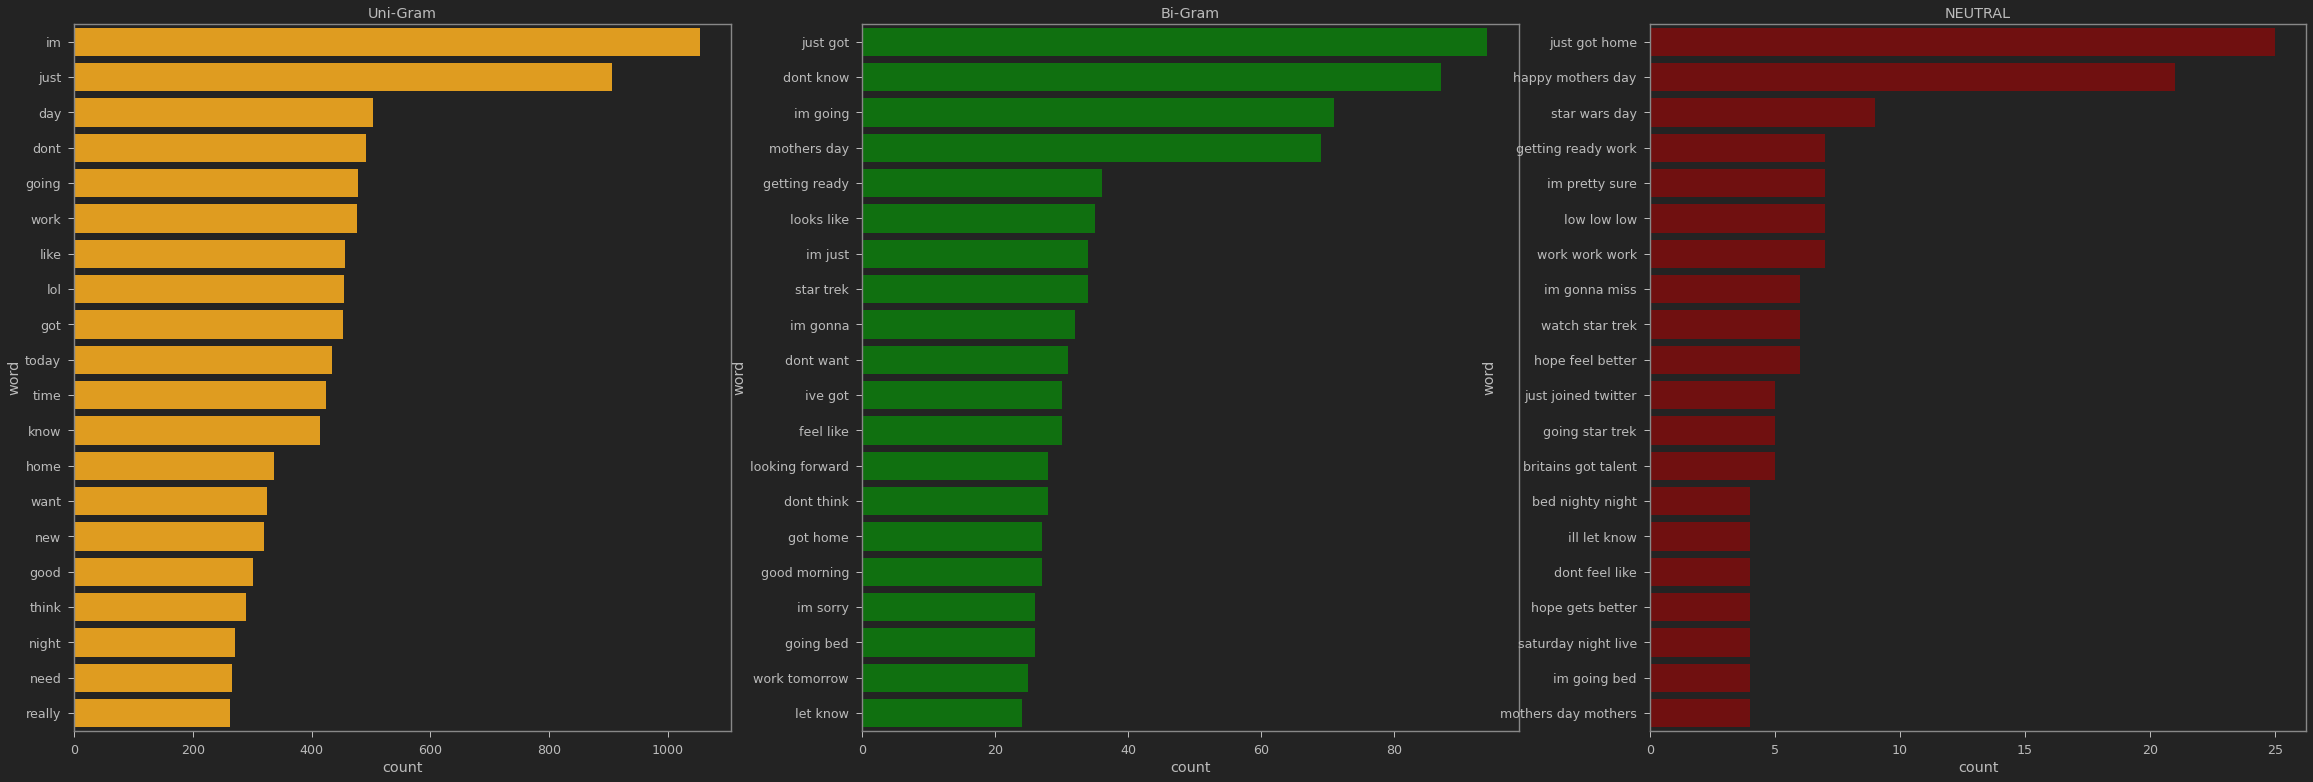

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[40, 13])
sns.barplot(df_neu_uni['count'], df_neu_uni['word'], ax=ax1, color="orange")
ax1.set_title('Uni-Gram')
sns.barplot(df_neu_bi['count'], df_neu_bi['word'], ax=ax2, color="green")
ax2.set_title('Bi-Gram')
sns.barplot(df_neu_tri['count'], df_neu_tri['word'], ax=ax3, color="maroon")
ax3.set_title('Tri-Gram')
plt.title('NEUTRAL')

###  Positive 

In [ ]:
positive_data = train_data.groupby('sentiment').get_group(('positive'))
positive_data

textID  ... extra_spaces
6      6e0c6d75b1  ...            0
9      fc2cbefa9d  ...            1
11     16fab9f95b  ...            0
21     e48b0b8a23  ...            0
25     e00c6ef376  ...            0
...           ...  ...          ...
27467  432e6de6c9  ...            0
27474  8f14bb2715  ...            0
27475  b78ec00df5  ...            1
27478  f67aae2310  ...            0
27479  ed167662a5  ...            0

[8582 rows x 12 columns]

In [ ]:
pos_uni = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "positive", 'text_clean'], (1, 1), 20)
pos_bi = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "positive", 'text_clean'], (2, 2), 20)
pos_tri = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "positive", 'text_clean'], (3, 3), 20)

In [ ]:
df_pos_uni = pd.DataFrame(pos_uni, columns=['word', 'count'])
df_pos_bi = pd.DataFrame(pos_bi, columns=['word', 'count'])
df_pos_tri = pd.DataFrame(pos_tri, columns=['word', 'count'])

Text(0.5, 1.0, 'Tri-Gram')

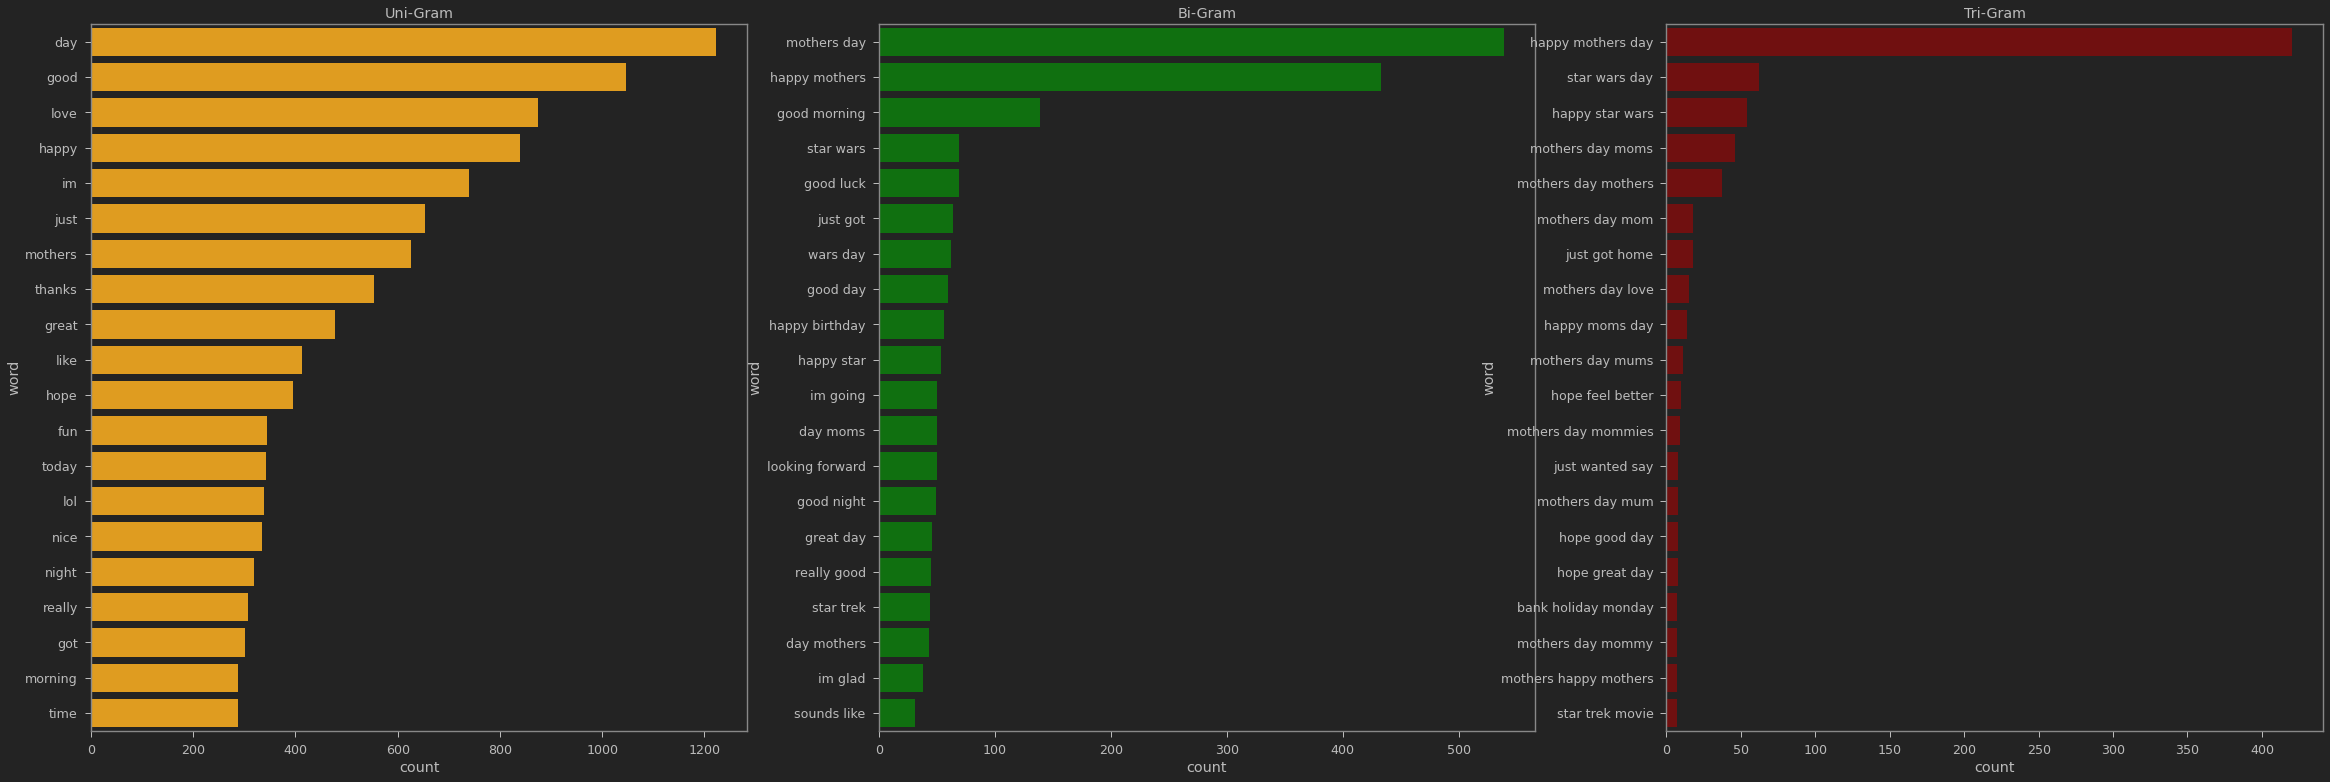

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[40, 13])
sns.barplot(df_pos_uni['count'], df_pos_uni['word'], ax=ax1, color="orange")
ax1.set_title('Uni-Gram')
sns.barplot(df_pos_bi['count'], df_pos_bi['word'], ax=ax2, color="green")
ax2.set_title('Bi-Gram')
sns.barplot(df_pos_tri['count'], df_pos_tri['word'], ax=ax3, color="maroon")
ax3.set_title('Tri-Gram')

###  Negative 

In [ ]:
negative_data = train_data.groupby('sentiment').get_group(('negative'))
negative_data

textID  ... extra_spaces
1      549e992a42  ...            0
2      088c60f138  ...            0
3      9642c003ef  ...            1
4      358bd9e861  ...            0
12     74a76f6e0a  ...            0
...           ...  ...          ...
27464  e7eecffdc8  ...            0
27470  778184dff1  ...            2
27472  8f5adc47ec  ...            0
27476  4eac33d1c0  ...            2
27477  4f4c4fc327  ...            2

[7781 rows x 12 columns]

In [ ]:
neg_uni = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "negative", 'text_clean'], (1, 1), 20)
neg_bi = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "negative", 'text_clean'], (2, 2), 20)
neg_tri = get_top_n_gram(
    train_data.loc[train_data['sentiment'] == "negative", 'text_clean'], (3, 3), 20)

In [ ]:
df_neg_uni = pd.DataFrame(neg_uni, columns=['word', 'count'])
df_neg_bi = pd.DataFrame(neg_bi, columns=['word', 'count'])
df_neg_tri = pd.DataFrame(neg_tri, columns=['word', 'count'])

Text(0.5, 1.0, 'Tri-Gram')

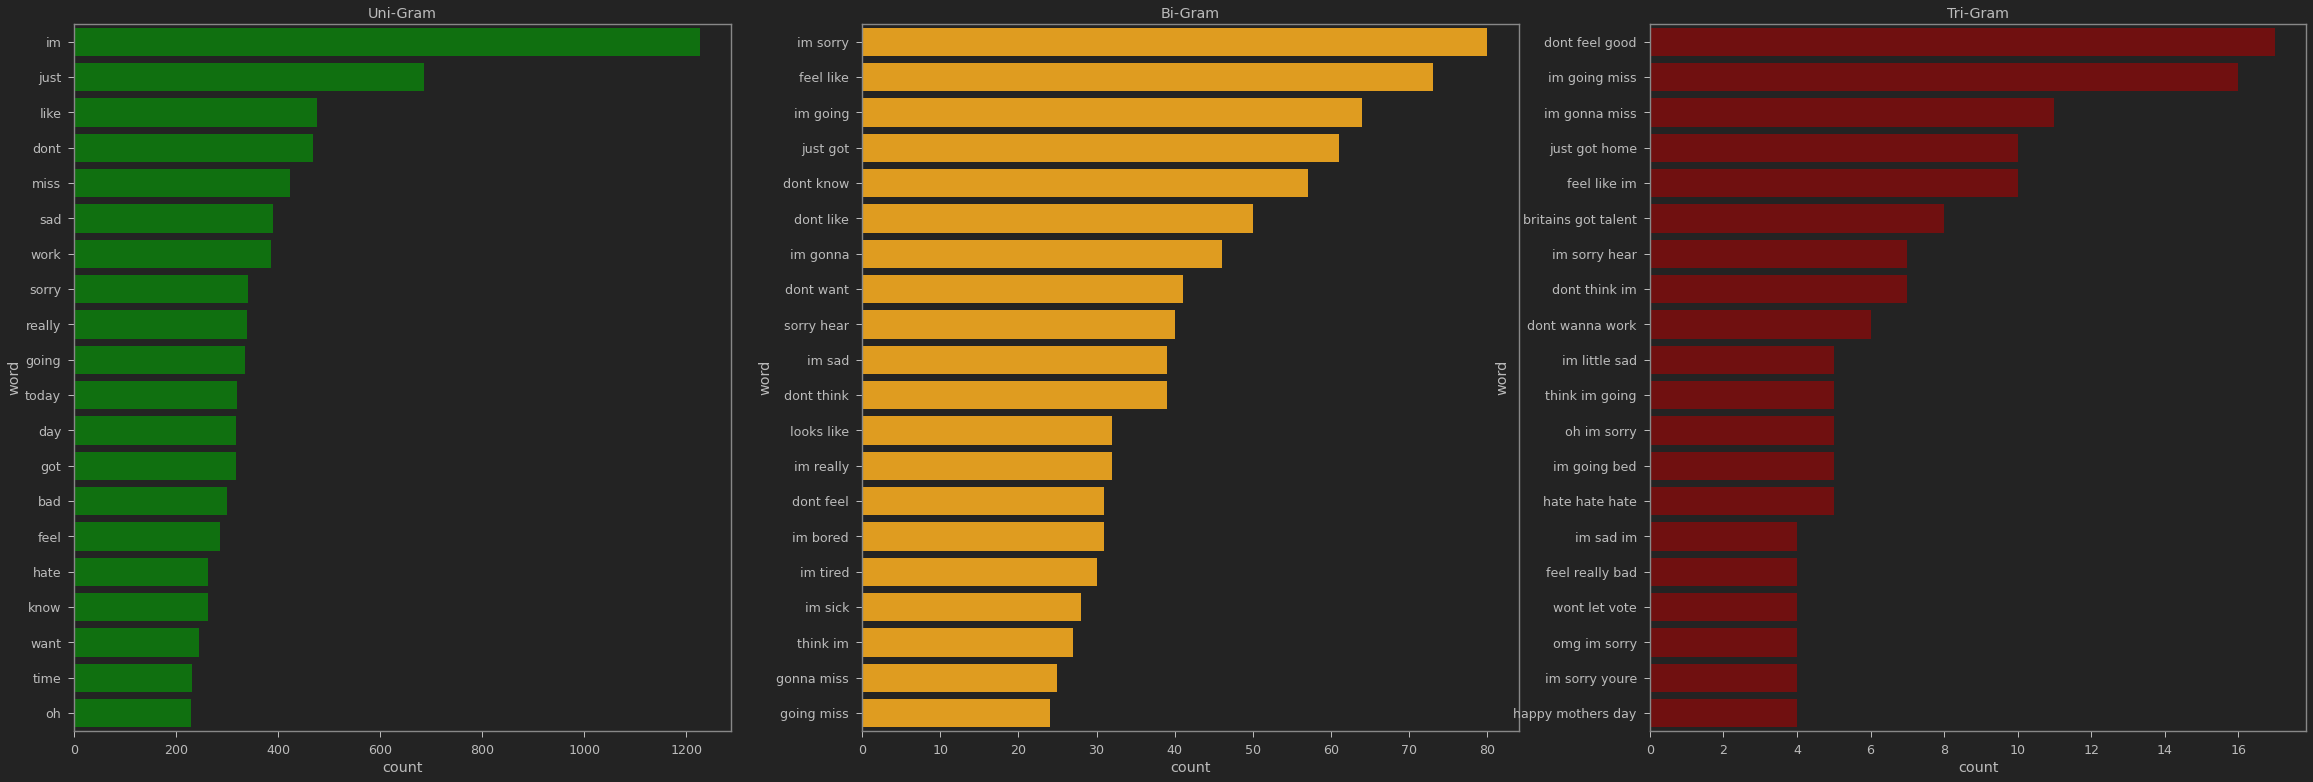

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[40, 13])
sns.barplot(df_neg_uni['count'], df_neg_uni['word'], ax=ax1, color="green")
ax1.set_title('Uni-Gram')
sns.barplot(df_neg_bi['count'], df_neg_bi['word'], ax=ax2, color="orange")
ax2.set_title('Bi-Gram')
sns.barplot(df_neg_tri['count'], df_neg_tri['word'], ax=ax3, color="maroon")
ax3.set_title('Tri-Gram')

In [ ]:
'''
negative_data['text_wc'].iplot(
    kind='bar',
    yTitle='Count',
    linecolor='black',
    color='green',
    title='Top 20 Unigrams in negative text',
    orientation='h')
neutral_data['text_wc'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text word count')
'''

"\nnegative_data['text_wc'].iplot(\n    kind='bar',\n    yTitle='Count',\n    linecolor='black',\n    color='green',\n    title='Top 20 Unigrams in negative text',\n    orientation='h')\nneutral_data['text_wc'].iplot(\n    kind='hist',\n    bins=50,\n    xTitle='text length',\n    linecolor='black',\n    yTitle='count',\n    title='Neutral Text word count')\n"

## 8. Wordclouds

#### Positive

In [ ]:
pos = train_data[train_data['sentiment'] == 'positive']['selected_text']
positive_text_clean = pos.apply(lambda x: text_preprocessing(x))

neg = train_data[train_data['sentiment'] == 'negative']['selected_text']
negative_text_clean = neg.apply(lambda x: text_preprocessing(x))

neu = train_data[train_data['sentiment'] == 'neutral']['selected_text']
neutral_text_clean = neu.apply(lambda x: text_preprocessing(x))

Text(0.5, 1.0, 'Neutral Words')

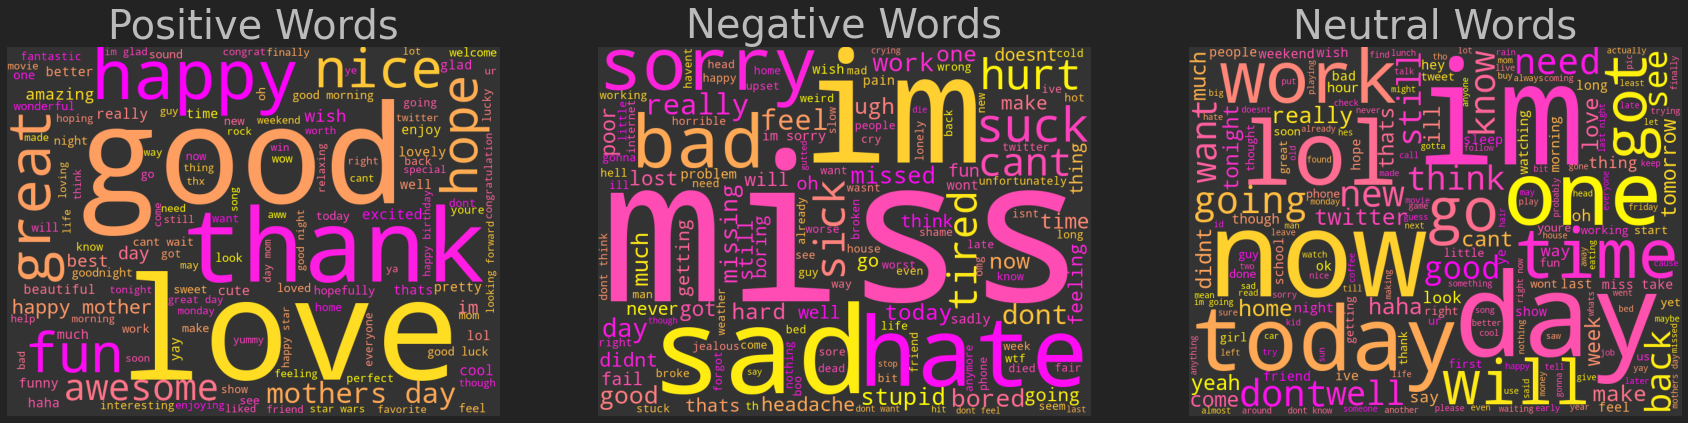

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud(width=800,
                       height=600,
                       min_font_size=14,
                       background_color="#333333",
                       colormap="spring")
wordcloud1.generate(" ".join(positive_text_clean))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Words', fontsize=40)

wordcloud2 = WordCloud(width=800,
                       height=600,
                       min_font_size=14,
                       background_color="#333333",
                       colormap="spring")
wordcloud2.generate(" ".join(negative_text_clean))

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Words', fontsize=40)

wordcloud3 = WordCloud(width=800,
                       height=600,
                       min_font_size=14,
                       background_color="#333333",
                       colormap="spring")
wordcloud3.generate(" ".join(neutral_text_clean))

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Words', fontsize=40)

In [ ]:
#negative_data.loc[negative_data['text'].str.contains('http')]

In [ ]:
#BERT #ROBERTA #RNN #LSTM #TRaNformer

## 9. (BERT)    
##### Bidirectional Encoder Representations from Transformers

    During pretraining, BERT uses Masked Language Models (MLM) and Next Sentence Prediction (NSP).

    MLM basically masks 80% of the 15% of the randomly selected input tokens and uses the other tokens to attempt to predict the mask (missing word)
    NSP is a binary classification loss for predicting whether two segments follow each other or are from different documents
    
    BERT uses [CLS] as a starting token and [SEP] as a separator token.

#####  Analyzing the BERT vocab list 

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

with open("vocabulary.txt", 'w', encoding="utf-8") as f:
    index = 0
    # For each token...
    for token in tokenizer.vocab.keys():
        # Write it out and escape any unicode characters.
        f.write("{}. {}\n\n".format(index, token))
        index+=1

In [ ]:
# Getting the tokens against the unique entities.
print("Token for" + " " + tokenizer.cls_token + " is ", tokenizer.cls_token_id)
print("Token for" + " " + tokenizer.sep_token + " is ", tokenizer.sep_token_id)
print("Token for" + " " + tokenizer.pad_token + " is ", tokenizer.pad_token_id)
print("Token for" + " " + tokenizer.unk_token + " is ", tokenizer.unk_token_id)
print("Token for" + " " + tokenizer.mask_token + " is ", tokenizer.mask_token_id)

Token for [CLS] is  101
Token for [SEP] is  102
Token for [PAD] is  0
Token for [UNK] is  100
Token for [MASK] is  103


In [ ]:
tokenizer.tokenize('i love strawberries',add_special_tokens=True)

['i', 'love', 'straw', '##berries']

In [ ]:
tokenizer.tokenize('beddings',add_special_tokens=True)

['bed', '##ding', '##s']

In [ ]:
tokenizer.tokenize('kroxldyphivc',add_special_tokens=True)

['k', '##ro', '##x', '##ld', '##yp', '##hi', '##vc']

In [ ]:
one_chars = []
one_chars_hashes = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():

    # Record any single-character tokens.
    if len(token) == 1:
        one_chars.append(token)

    # Record single-character tokens preceded by the two hashes.
    elif len(token) == 3 and token[0:2] == '##':
        one_chars_hashes.append(token)

In [ ]:
print('Number of single character tokens:', len(one_chars), '\n')
# Print all of the single characters, 40 per row.
# For every batch of 40 tokens...

for i in range(0, len(one_chars), 40):

    # Limit the end index so we don't go past the end of the list.
    end = min(i + 40, len(one_chars) + 1)

    # Print out the tokens, separated by a space.
    print(' '.join(one_chars[i:end]))

Number of single character tokens: 997 

! " # $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; < = > ? @ [ \ ] ^ _ ` a b
c d e f g h i j k l m n o p q r s t u v w x y z { | } ~ ¡ ¢ £ ¤ ¥ ¦ § ¨ © ª « ¬
® ° ± ² ³ ´ µ ¶ · ¹ º » ¼ ½ ¾ ¿ × ß æ ð ÷ ø þ đ ħ ı ł ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɛ ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ː ˡ ˢ ˣ ˤ α β γ δ
ε ζ η θ ι κ λ μ ν ξ ο π ρ ς σ τ υ φ χ ψ ω а б в г д е ж з и к л м н о п р с т у
ф х ц ч ш щ ъ ы ь э ю я ђ є і ј љ њ ћ ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ
ք ־ א ב ג ד ה ו ז ח ט י ך כ ל ם מ ן נ ס ע ף פ ץ צ ק ר ש ת ، ء ا ب ة ت ث ج ح خ د
ذ ر ز س ش ص ض ط ظ ع غ ـ ف ق ك ل م ن ه و ى ي ٹ پ چ ک گ ں ھ ہ ی ے अ आ उ ए क ख ग च
ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ ই উ এ ও ক খ গ চ ছ জ
ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப ம ய ர ல ள வ ா ி ு ே
ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད ན པ བ མ འ ར ལ ས မ ა
ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ ᄋ ᄌ ᄎ ᄏ ᄐ ᄑ ᄒ ᅡ ᅢ ᅥ ᅦ ᅧ ᅩ ᅪ ᅭ ᅮ

In [ ]:
print('Number of single character tokens with hashes:', len(one_chars_hashes), '\n')
# Print all of the single characters, 40 per row.
# Strip the hash marks, since they just clutter the display.

tokens = [token.replace('##', '') for token in one_chars_hashes]
# For every batch of 40 tokens...
for i in range(0, len(tokens), 40):
    # Limit the end index so we don't go past the end of the list.
    end = min(i + 40, len(tokens) + 1)
    # Print out the tokens, separated by a space.
    print(' '.join(tokens[i:end]))

Number of single character tokens with hashes: 997 

s a e i n o d r y t l m u h k c g p 2 z 1 b 3 f 4 6 7 x v 8 5 9 0 w j q ° ₂ а и
² ₃ ı ₁ ⁺ ½ о ه ي α е د ن ν ø р ₄ ₀ ر я ³ ι ł н ᵢ ₙ ß ة ς م − т ː ل ь к ♭ η ی в
ا × ¹ ы ה ɛ л ! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ ¡
¢ £ ¤ ¥ ¦ § ¨ © ª « ¬ ® ± ´ µ ¶ · º » ¼ ¾ ¿ æ ð ÷ þ đ ħ ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ˡ ˢ ˣ ˤ β γ δ ε ζ
θ κ λ μ ξ ο π ρ σ τ υ φ χ ψ ω б г д ж з м п с у ф х ц ч ш щ ъ э ю ђ є і ј љ њ ћ
ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ ք ־ א ב ג ד ו ז ח ט י ך כ ל ם מ ן נ ס
ע ף פ ץ צ ק ר ש ת ، ء ب ت ث ج ح خ ذ ز س ش ص ض ط ظ ع غ ـ ف ق ك و ى ٹ پ چ ک گ ں ھ
ہ ے अ आ उ ए क ख ग च ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ
ই উ এ ও ক খ গ চ ছ জ ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப
ம ய ர ல ள வ ா ி ு ே ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད
ན པ བ མ འ ར ལ ས မ ა ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ

Maximum token length: 18


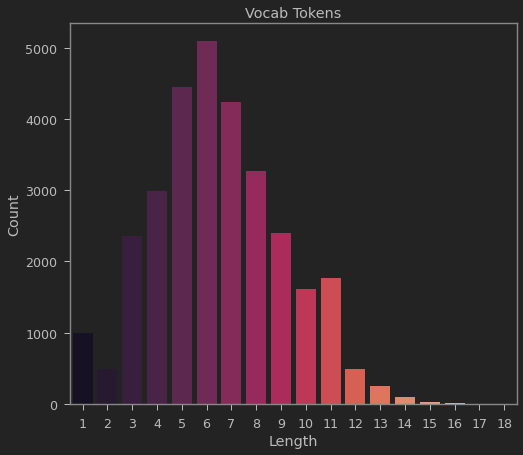

In [ ]:
token_lenght = [len(token)  for token in tokenizer.vocab.keys()]
sns.countplot(token_lenght,color="r",palette= "rocket")
plt.title('Vocab Tokens')
plt.xlabel('Length')
plt.ylabel('Count')

print('Maximum token length:', max(token_lenght))

In [ ]:
num_sub = 0

sub_len = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():
    # If it's a subword...
    if len(token) >= 2 and token[0:2] == '##':   
        # Tally all subwords
        num_sub += 1
        # Measure the sub word length (without the hashes)
        length = len(token) - 2
        # Record the lengths.        
        sub_len.append(length)
        
vocab_size = len(tokenizer.vocab.keys())
print('Number of subwords: {:,} of {:,}'.format(num_sub, vocab_size))
# Calculate the percentage of words that are '##' subwords.
prcnt = float(num_sub) / vocab_size * 100.0
print('%.1f%%' % prcnt)

Number of subwords: 5,828 of 30,522
19.1%


Text(0, 0.5, 'Count')

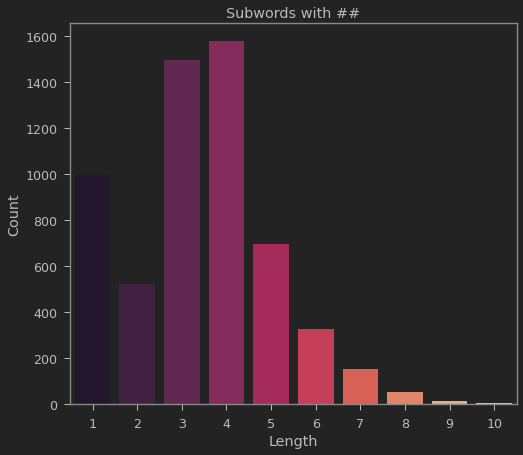

In [ ]:
sns.countplot(sub_len,palette="rocket")
plt.title('Subwords with ##')
plt.xlabel('Length')
plt.ylabel('Count')

###  Bert Question Answering 

    BERT expects input data in a specific format i.e

    1. Tokenized dataset
    2. All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column.
    3. We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".

    From the Hugging face documentation The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.

    4. Adding special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]).



#####  Config 


In [ ]:
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 16
    EPOCHS = 5
    BERT_PATH = "bert-base-uncased"
    MODEL_PATH = model
    TRAINING_FILE = train_data
    TOKENIZER = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad', do_lower_case=True)

#####  Tokenization (Word Embedding) 

In [222]:
# Bert - Base model - with no capitalized words
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad', do_lower_case=True) 

In [ ]:
# Tokenizing the first text
print(train_data['text'][6]) # original sentence
print(tokenizer.tokenize(train_data['text'][6], add_special_tokens=True))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data['text'][6])))

2am feedings for the baby are fun when he is all smiles and coos
['2a', '##m', 'feeding', '##s', 'for', 'the', 'baby', 'are', 'fun', 'when', 'he', 'is', 'all', 'smiles', 'and', 'co', '##os']
[23409, 2213, 8521, 2015, 2005, 1996, 3336, 2024, 4569, 2043, 2002, 2003, 2035, 8451, 1998, 2522, 2891]


#####  Maximum Lenght 

In [ ]:
# calculating length of the longest text

max_len = 0

for text in train_data['text']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print('Max length: ', max_len)

Max length:  110


#####  Initialize Wandb And Sweep Configs 

In [5]:
import wandb
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {

        'learning_rate': {
            'values': [ 5e-5, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'epochs':{
            'values':[2, 3, 4]
        }
    }
}
sweep_defaults = {
        'learning_rate': 5e-5,
       
        'batch_size': 32,

        'epochs':2
}

sweep_id = wandb.sweep(sweep_config)

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: jejd6f9c
Sweep URL: https://app.wandb.ai/usman_farooq/uncategorized/sweeps/jejd6f9c


    What we get are 3 tensors. Let me briefly go over them:

    1) input_ids : list of token ids to be fed to a model. We can see that all token ids have been padded to a length of 150.
    2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.
    3) token_type_ids : list of token type ids to be fed to a model. These are also in the form of 0s and 1s and help to differentiate between the two sequences. The first sequence is the sentiment and the second is the text. Remember we had concatanated them. But why we need it? This is because the model has to differentiate between the two sequences and it will use these IDs to place a SEP token between them.

    The last thing that we have to do before we begin training the model is to convert the selected text column as a combination of the START and END tokens.

    After going through a lot of resources, I think there is no point in reinventing the wheel. The following kernel from Abhishek clearly explains the whole process very well.

In [ ]:
'''
question = train_data['text'].values
answers = train_data['sentiment'].values
'''

"\nquestion = train_data['text'].values\nanswers = train_data['sentiment'].values\n"

In [6]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


##### <font color='teal'> Data loader </font> </font>

In [7]:
use_cuda = True

In [8]:
train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')
sub_df = pd.read_csv('/content/data/sample_submission.csv')

train = np.array(train_df)
test = np.array(test_df)

!mkdir -p data

In [9]:
%%time

"""
Prepare training data in QA-compatible format
"""

# Adpated from https://www.kaggle.com/cheongwoongkang/roberta-baseline-starter-simple-postprocessing
def find_all(input_str, search_str):
    l1 = []
    length = len(input_str)
    index = 0
    while index < length:
        i = input_str.find(search_str, index)
        if i == -1:
            return l1
        l1.append(i)
        index = i + 1
    return l1

def do_qa_train(train):

    output = []
    for line in train:
        context = line[1]

        qas = []
        question = line[-1]
        qid = line[0]
        answers = []
        answer = line[2]
        if type(answer) != str or type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answer_starts = find_all(context, answer)
        for answer_start in answer_starts:
            answers.append({'answer_start': answer_start, 'text': answer.lower()})
            break
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})

        output.append({'context': context.lower(), 'qas': qas})
        
    return output

qa_train = do_qa_train(train)

with open('data/train.json', 'w') as outfile:
    json.dump(qa_train, outfile)

nan <class 'float'>
nan <class 'float'>
neutral <class 'str'>
trying to understand why WHY i joined twitter.....e <class 'str'>
nan <class 'float'>
nan <class 'float'>
CPU times: user 820 ms, sys: 83.8 ms, total: 904 ms
Wall time: 905 ms


In [184]:
%%time

"""
Prepare testing data in QA-compatible format
"""

def do_qa_test(test):
    output = []
    for line in test:
        context = line[1]
        qas = []
        question = line[-1]
        qid = line[0]
        if type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answers = []
        answers.append({'answer_start': 1000000, 'text': '__None__'})
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})
        output.append({'context': context.lower(), 'qas': qas})
    return output

qa_test = do_qa_test(test)

with open('data/test.json', 'w') as outfile:
    json.dump(qa_test, outfile)

CPU times: user 342 ms, sys: 4.57 ms, total: 347 ms
Wall time: 346 ms


In [11]:
!pip install simpletransformers

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 204kB 8.7MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e0489e5d280a9108cf3243f50012a41df0f2c5adb261741b2de6717a51ff6a1c
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


##### <font color='teal'> Model </font> </font>

In [12]:
from simpletransformers.question_answering import QuestionAnsweringModel

MODEL_PATH = 'bert-base-uncased'
wandb.init()
# Create the QuestionAnsweringModel
model = QuestionAnsweringModel('bert', 
                               MODEL_PATH, 
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 5,
                                     'max_seq_length': 128,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=True)

model.train_model('data/train.json')

add example index and unique id: 100%|██████████| 24692/24692 [00:00<00:00, 809158.03it/s]


Running loss: 4.661366

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Running loss: 0.540653

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Running loss: 0.704897


Running loss: 1.190246


Running loss: 0.090330


Running loss: 0.326777


Running loss: 0.332248



In [147]:
#Log the Avg. train loss
wandb.log({'avg_train_loss':avg_train_loss})

In [14]:
wandb.agent(sweep_id,function=train)

wandb: Agent Starting Run: q698986p with config:
	batch_size: 32
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:32:38,702 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'q698986p', 'run_storage_id': 'UnVuOnYxOnE2OTg5ODZwOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
2020-06-28 21:32:44,212 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 2}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '8f7e2dr2', 'run_storage_id': 'UnVuOnYxOjhmN2UyZHIyOnVuY2F0ZWdvcml6ZW

wandb: Agent Starting Run: 8f7e2dr2 with config:
	batch_size: 32
	epochs: 2
	learning_rate: 5e-05


2020-06-28 21:32:49,688 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 2}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'c3igisnl', 'run_storage_id': 'UnVuOnYxOmMzaWdpc25sOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: c3igisnl with config:
	batch_size: 16
	epochs: 2
	learning_rate: 2e-05


2020-06-28 21:32:55,179 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 2}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': 'rw8lvkx9', 'run_storage_id': 'UnVuOnYxOnJ3OGx2a3g5OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: rw8lvkx9 with config:
	batch_size: 16
	epochs: 2
	learning_rate: 3e-05


2020-06-28 21:33:00,661 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 3}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'fyybu136', 'run_storage_id': 'UnVuOnYxOmZ5eWJ1MTM2OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: fyybu136 with config:
	batch_size: 16
	epochs: 3
	learning_rate: 2e-05


2020-06-28 21:33:06,168 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'ol94dfp7', 'run_storage_id': 'UnVuOnYxOm9sOTRkZnA3OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: ol94dfp7 with config:
	batch_size: 32
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:33:12,245 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'e6arfsms', 'run_storage_id': 'UnVuOnYxOmU2YXJmc21zOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: e6arfsms with config:
	batch_size: 32
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:33:17,988 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 4}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': 'yp4xs6xq', 'run_storage_id': 'UnVuOnYxOnlwNHhzNnhxOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: yp4xs6xq with config:
	batch_size: 32
	epochs: 4
	learning_rate: 3e-05


2020-06-28 21:33:23,489 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 2}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '1klel22d', 'run_storage_id': 'UnVuOnYxOjFrbGVsMjJkOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 1klel22d with config:
	batch_size: 16
	epochs: 2
	learning_rate: 5e-05


2020-06-28 21:33:28,966 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'khkbaj7h', 'run_storage_id': 'UnVuOnYxOmtoa2JhajdoOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: khkbaj7h with config:
	batch_size: 16
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:33:34,463 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 2}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'uu9825g7', 'run_storage_id': 'UnVuOnYxOnV1OTgyNWc3OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: uu9825g7 with config:
	batch_size: 16
	epochs: 2
	learning_rate: 5e-05


2020-06-28 21:33:39,947 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'h0uhov4m', 'run_storage_id': 'UnVuOnYxOmgwdWhvdjRtOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: h0uhov4m with config:
	batch_size: 16
	epochs: 4
	learning_rate: 5e-05


2020-06-28 21:33:45,416 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 2}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'r0x801s2', 'run_storage_id': 'UnVuOnYxOnIweDgwMXMyOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: r0x801s2 with config:
	batch_size: 32
	epochs: 2
	learning_rate: 2e-05


2020-06-28 21:33:50,886 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '2d6s6ki2', 'run_storage_id': 'UnVuOnYxOjJkNnM2a2kyOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 2d6s6ki2 with config:
	batch_size: 32
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:33:56,378 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 3}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': 'yp735ftx', 'run_storage_id': 'UnVuOnYxOnlwNzM1ZnR4OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: yp735ftx with config:
	batch_size: 16
	epochs: 3
	learning_rate: 3e-05


2020-06-28 21:34:01,879 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'dz80o0yy', 'run_storage_id': 'UnVuOnYxOmR6ODBvMHl5OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: dz80o0yy with config:
	batch_size: 16
	epochs: 4
	learning_rate: 5e-05


2020-06-28 21:34:07,405 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'cd75bxnt', 'run_storage_id': 'UnVuOnYxOmNkNzVieG50OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: cd75bxnt with config:
	batch_size: 32
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:34:12,924 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': 'f801z3in', 'run_storage_id': 'UnVuOnYxOmY4MDF6M2luOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: f801z3in with config:
	batch_size: 16
	epochs: 4
	learning_rate: 3e-05


2020-06-28 21:34:18,403 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'vs4xwy3l', 'run_storage_id': 'UnVuOnYxOnZzNHh3eTNsOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: vs4xwy3l with config:
	batch_size: 32
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:34:23,910 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 2}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '1v30fxai', 'run_storage_id': 'UnVuOnYxOjF2MzBmeGFpOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 1v30fxai with config:
	batch_size: 32
	epochs: 2
	learning_rate: 5e-05


2020-06-28 21:34:29,390 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': '9sc70946', 'run_storage_id': 'UnVuOnYxOjlzYzcwOTQ2OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 9sc70946 with config:
	batch_size: 32
	epochs: 3
	learning_rate: 3e-05
wandb: Agent Starting Run: ppznpzhd with config:
	batch_size: 16
	epochs: 4
	learning_rate: 5e-05


2020-06-28 21:34:34,898 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'ppznpzhd', 'run_storage_id': 'UnVuOnYxOnBwem5wemhkOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: fg2d0d29 with config:
	batch_size: 16
	epochs: 3
	learning_rate: 2e-05


2020-06-28 21:34:40,406 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 3}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'fg2d0d29', 'run_storage_id': 'UnVuOnYxOmZnMmQwZDI5OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
2020-06-28 21:34:45,875 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'ycattaa0', 'run_storage_id': 'UnVuOnYxOnljYXR0YWEwOnVuY2F0ZWdvcml6ZW

wandb: Agent Starting Run: ycattaa0 with config:
	batch_size: 32
	epochs: 3
	learning_rate: 2e-05


2020-06-28 21:34:51,391 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 2}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '9z77p5zk', 'run_storage_id': 'UnVuOnYxOjl6NzdwNXprOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 9z77p5zk with config:
	batch_size: 16
	epochs: 2
	learning_rate: 5e-05


2020-06-28 21:34:56,859 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'dsl61zvl', 'run_storage_id': 'UnVuOnYxOmRzbDYxenZsOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: dsl61zvl with config:
	batch_size: 32
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:35:02,330 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': 'vw32z8wa', 'run_storage_id': 'UnVuOnYxOnZ3MzJ6OHdhOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: vw32z8wa with config:
	batch_size: 32
	epochs: 3
	learning_rate: 3e-05


2020-06-28 21:35:07,801 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 3}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': '21h35u0v', 'run_storage_id': 'UnVuOnYxOjIxaDM1dTB2OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 21h35u0v with config:
	batch_size: 16
	epochs: 3
	learning_rate: 3e-05


2020-06-28 21:35:13,290 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 3e-05}}, 'program': '', 'run_id': 'g8gteg4y', 'run_storage_id': 'UnVuOnYxOmc4Z3RlZzR5OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: g8gteg4y with config:
	batch_size: 16
	epochs: 4
	learning_rate: 3e-05


2020-06-28 21:35:18,796 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'cs1lcv7v', 'run_storage_id': 'UnVuOnYxOmNzMWxjdjd2OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: cs1lcv7v with config:
	batch_size: 16
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:35:24,296 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 2}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': '0t5qmw5n', 'run_storage_id': 'UnVuOnYxOjB0NXFtdzVuOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 0t5qmw5n with config:
	batch_size: 32
	epochs: 2
	learning_rate: 2e-05


2020-06-28 21:35:29,773 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'l1mog3a2', 'run_storage_id': 'UnVuOnYxOmwxbW9nM2EyOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: l1mog3a2 with config:
	batch_size: 32
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:35:35,256 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 4}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'r7y2agwt', 'run_storage_id': 'UnVuOnYxOnI3eTJhZ3d0OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: r7y2agwt with config:
	batch_size: 32
	epochs: 4
	learning_rate: 5e-05


2020-06-28 21:35:40,710 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '011k1m5g', 'run_storage_id': 'UnVuOnYxOjAxMWsxbTVnOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 011k1m5g with config:
	batch_size: 32
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:35:46,175 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'x8lees84', 'run_storage_id': 'UnVuOnYxOng4bGVlczg0OnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: x8lees84 with config:
	batch_size: 16
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:35:51,668 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 32}, 'epochs': {'value': 4}, 'learning_rate': {'value': 2e-05}}, 'program': '', 'run_id': 'zlkztdeb', 'run_storage_id': 'UnVuOnYxOnpsa3p0ZGViOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: zlkztdeb with config:
	batch_size: 32
	epochs: 4
	learning_rate: 2e-05


2020-06-28 21:35:57,156 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 3}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': 'hzevji8b', 'run_storage_id': 'UnVuOnYxOmh6ZXZqaThiOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: hzevji8b with config:
	batch_size: 16
	epochs: 3
	learning_rate: 5e-05


2020-06-28 21:36:02,613 - wandb.wandb_agent - ERROR - Exception while processing command: {'args': {'batch_size': {'value': 16}, 'epochs': {'value': 2}, 'learning_rate': {'value': 5e-05}}, 'program': '', 'run_id': '651mrisn', 'run_storage_id': 'UnVuOnYxOjY1MW1yaXNuOnVuY2F0ZWdvcml6ZWQ6dXNtYW5fZmFyb29x', 'type': 'run'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 265, in _process_command
    result = self._command_run(command)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 309, in _command_run
    if self._function:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


wandb: Agent Starting Run: 651mrisn with config:
	batch_size: 16
	epochs: 2
	learning_rate: 5e-05


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


In [15]:
result, text = model.eval_model('data/train.json')

print(result)

print('-------------------')

add example index and unique id: 100%|██████████| 24692/24692 [00:00<00:00, 814708.58it/s]



{'correct': 19442, 'similar': 1565, 'incorrect': 3685, 'eval_loss': -8.218416308213639}
{'correct_text': {'cb774db0d1': 'i`d have responded, if i were going', '549e992a42': 'sooo sad', '088c60f138': 'bullying me', '9642c003ef': 'leave me alone', '358bd9e861': 'sons of ****,', '28b57f3990': 'http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth', '6e0c6d75b1': 'fun', '50e14c0bb8': 'soooo high', 'e050245fbd': 'both of you', 'fc2cbefa9d': 'wow... u just became cooler.', '2339a9b08b': 'as much as i love to be hopeful, i reckon the chances are minimal =p i`m never gonna get my cake and stuff', '16fab9f95b': 'like', '74a76f6e0a': 'dangerously', '04dd1d2e34': 'lost', 'bbe3cbf620': 'test test from the lg env2', '8a939bfb59': 'uh oh, i am sunburned', '3440297f8b': '*sigh*', '919fa93391': 'sick', '40e7becabf': 'hes just not that into you', 'e48b0b8a23': 'interesting.', '7de057cf40': 'is cleaning the house for her family who is comming later today..', '9ce5

In [198]:
Accuracy = (19442-1565)/19442*100
print("ACCURACY : "  + str(Accuracy)  + "% ")

ACCURACY : 91.95041662380413% 


In [154]:
%%time

predictions = model.predict(qa_test)
predictions_df = pd.DataFrame.from_dict(predictions)

add example index and unique id: 100%|██████████| 3534/3534 [00:00<00:00, 551315.57it/s]



CPU times: user 45.3 s, sys: 15.8 s, total: 1min 1s
Wall time: 1min 5s


In [210]:
predictions_df[2][1]

{'id': 'eee518ae67',
 'probability': [0.8620710167683189,
  0.07034289045251242,
  0.038564865952660086,
  0.02401334216126079,
  0.0019594300982075917,
  0.0010742401768661528,
  0.00044944330141660776,
  0.0004376796766425551,
  0.00039402423929118353,
  0.00027163374943801953,
  0.00022714016236120767,
  8.030492980146345e-05,
  4.2341839579739255e-05,
  1.2519427714276331e-05,
  1.2191747115739369e-05,
  1.1815198483286143e-05,
  1.17262876868106e-05,
  8.39577092311577e-06,
  7.566469630603937e-06,
  7.431589909955959e-06,
  1.7891988399512606e-13]}

In [318]:
predictions_df[2][0]

{'answer': ['such a shame!',
  ', such a shame!',
  'shame!',
  'such a shame',
  ', such a shame',
  'shame',
  'recession hit veronique branquinho, she has to quit her company, such a shame!',
  'a shame!',
  '!',
  'company, such a shame!',
  'she has to quit her company, such a shame!',
  ', she has to quit her company, such a shame!',
  'such',
  'recession hit veronique branquinho, she has to quit her company, such a shame',
  'a shame',
  'has to quit her company, such a shame!',
  'hit veronique branquinho, she has to quit her company, such a shame!',
  'her company, such a shame!',
  'company, such a shame',
  'quinho, she has to quit her company, such a shame!',
  ''],
 'id': 'eee518ae67'}

In [367]:
# Tokenizing the first text
context = 'recession hit branquinho, she has to quit her company, such a shame!'
selected_text = 'such a shame!'
question = 'negative'
print(text) # original sentence
print(tokenizer.tokenize(text, add_special_tokens=True))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text)))

recession hit veronique branquinho, she has to quit her company, such a shame!
['recession', 'hit', 've', '##ron', '##ique', 'bran', '##quin', '##ho', ',', 'she', 'has', 'to', 'quit', 'her', 'company', ',', 'such', 'a', 'shame', '!']
[19396, 2718, 2310, 4948, 7413, 24905, 12519, 6806, 1010, 2016, 2038, 2000, 8046, 2014, 2194, 1010, 2107, 1037, 9467, 999]


In [368]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, context)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 21 tokens.


In [369]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
negative      4,997

[SEP]           102

recession    19,396
hit           2,718
bran         24,905
##quin       12,519
##ho          6,806
,             1,010
she           2,016
has           2,038
to            2,000
quit          8,046
her           2,014
company       2,194
,             1,010
such          2,107
a             1,037
shame         9,467
!               999

[SEP]           102



In [370]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [371]:
from transformers import BertForQuestionAnswering

mod = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

In [372]:
start_scores, end_scores = mod(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

In [373]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: ", she has"


In [374]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

In [375]:
plt.rcParams["figure.figsize"] = (16,8)

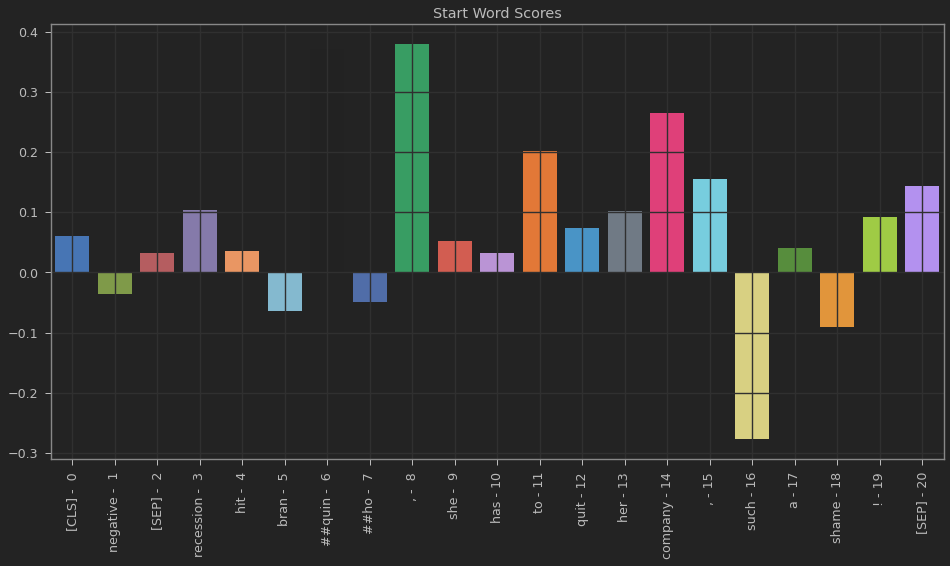

In [376]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

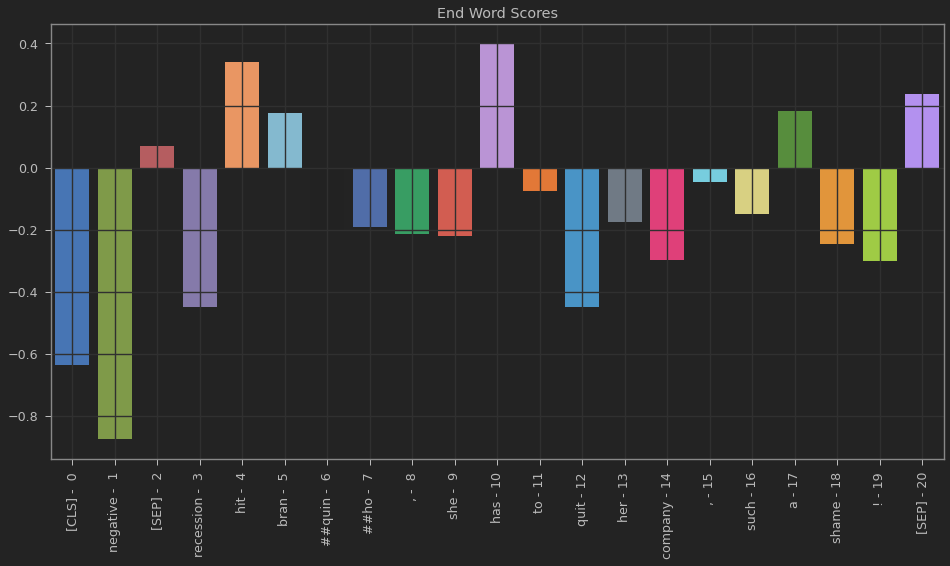

In [377]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()